# P3: Préparez des données pour un organisme de santé publique 

# Outils ( functions, automations etc ...)

In [15]:
def calculate_missing_data_percent(df):
    missing_data_mean =  np.round(df.isnull().mean() * 100, 2)
    return missing_data_mean


def calculate_missing_values(df):
    """
    This function calculates the sum and percentage of missing values for a given list of qualitative features in a dataframe.

    Parameters:
    df (pandas.DataFrame): The input dataframe.
    features_qualitatives (list): A list of qualitative feature names.

    Returns:
    pandas.DataFrame: A dataframe containing the sum and percentage of missing values for each qualitative feature.
    """
    # Calculate the sum of missing values for each qualitative feature
    missing_data_sum = df.isnull().sum()

    # Calculate the percentage of missing values for each qualitative feature
    missing_data_mean = calculate_missing_data_percent(df)

    # Create a new dataframe with the sum and percentage of missing values
    missing_data = pd.concat([missing_data_sum, missing_data_mean], axis=1)
    missing_data.columns = ['Missing Values', 'Missing Values (%)']

    # Sort the dataframe by the percentage of missing values in descending order
    missing_data = missing_data.sort_values(by='Missing Values (%)', ascending=False)

    return missing_data


def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

## Partie 1: Nettoyage et filtration des feautures et produits

### Importation des outils

In [16]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msn

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

pd.set_option('display.max_colwidth', 100)


### Data load & understanding

In [17]:
open_food_df = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t', low_memory=False)

<Axes: >

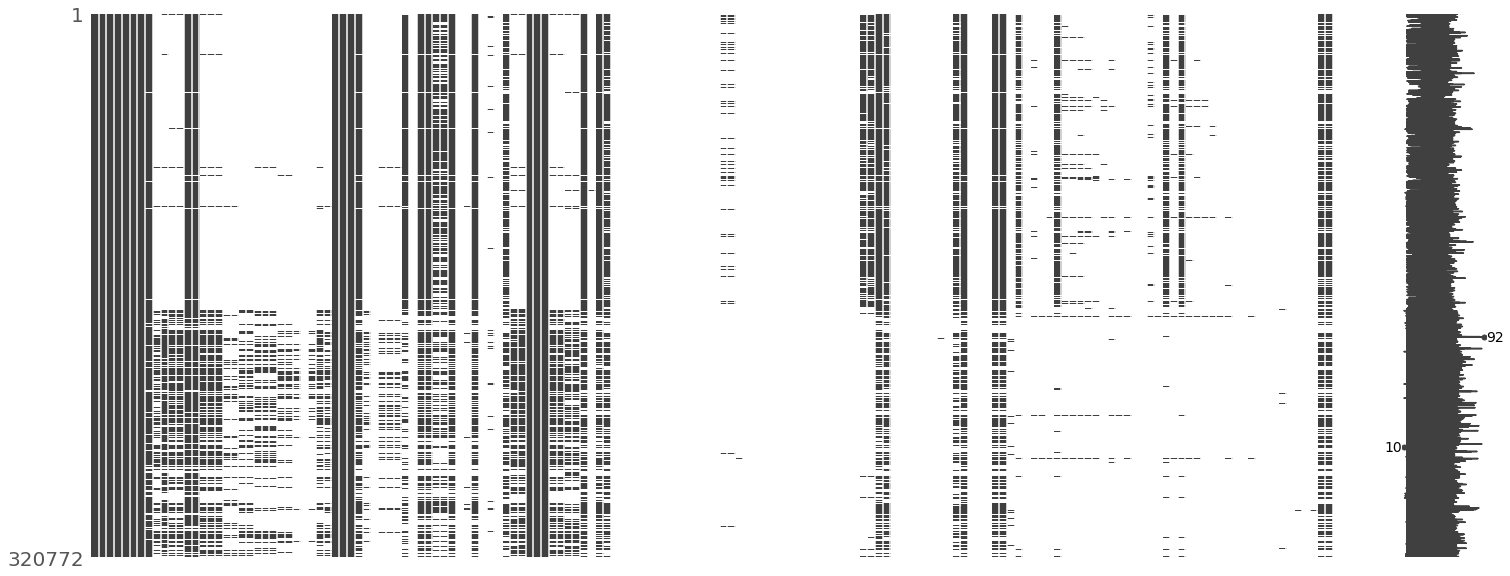

In [18]:
msn.matrix(open_food_df)

In [19]:
open_food_df.sample(2)

code  \
174850  1208101452196   
254944  3760231780061   

                                                                                      url  \
174850         http://world-fr.openfoodfacts.org/produit/1208101452196/galettes-pour-nems   
254944  http://world-fr.openfoodfacts.org/produit/3760231780061/recette-n-11-carre-suisse   

                creator   created_t      created_datetime last_modified_t  \
174850  date-limite-app  1487586607  2017-02-20T10:30:07Z      1487586607   
254944           elbeho  1446754994  2015-11-05T20:23:14Z      1446756347   

       last_modified_datetime        product_name                generic_name  \
174850   2017-02-20T10:30:07Z  Galettes pour nems                         NaN   
254944   2015-11-05T20:45:47Z        recette n°11  Chocolat au lait des Alpes   

       quantity packaging packaging_tags         brands   brands_tags  \
174850    200 g    sachet         sachet            NaN           NaN   
254944     100g    Carton         carton  +carré suisse  carre-suisse   

               categories                                    categories_tags  \
174850                NaN                                                NaN   
254944  Chocolats au lait  en:sugary-snacks,en:chocolates,en:milk-chocolates   

                                    categories_fr       origins  origins_tags  \
174850                                        NaN           NaN           NaN   
254944  Snacks sucrés,Chocolats,Chocolats au lait  Alpes,Suisse  alpes,suisse   

       manufacturing_places manufacturing_places_tags  \
174850                  NaN                       NaN   
254944               Suisse                    suisse   

                               labels  \
174850                            NaN   
254944  FSC C104754,FSC mix,MyClimate   

                                          labels_tags  \
174850                                            NaN   
254944  en:fsc,en:fsc-mix,fr:fsc-c104754,fr:myclimate   

                                labels_fr emb_codes emb_codes_tags  \
174850                                NaN       NaN            NaN   
254944  FSC,FSC Mix,Fsc-c104754,Myclimate       NaN            NaN   

       first_packaging_code_geo cities cities_tags purchase_places stores  \
174850                      NaN    NaN         NaN             NaN    NaN   
254944                      NaN    NaN         NaN             NaN    NaN   

       countries countries_tags countries_fr  \
174850     en:FR      en:france       France   
254944    France      en:france       France   

                                                                           ingredients_text  \
174850                                                                                  NaN   
254944  _Lait_ entier en poudre, beurre de cacao, sucre, pâte de cacao, gousses de vanille.   

       allergens allergens_fr                       traces  \
174850       NaN          NaN                          NaN   
254944      Lait          NaN  Noisettes,arachides,amandes   

               traces_tags                 traces_fr serving_size  \
174850                 NaN                       NaN          NaN   
254944  en:nuts,en:peanuts  Fruits à coque,Arachides          NaN   

        no_nutriments  additives_n  \
174850            NaN          NaN   
254944            NaN          0.0   

                                                                                                  additives  \
174850                                                                                                  NaN   
254944   [ lait-entier-en-poudre -> fr:lait-entier-en-poudre  ]  [ lait-entier-en -> fr:lait-entier-en  ...   

       additives_tags additives_fr  ingredients_from_palm_oil_n  \
174850            NaN          NaN                          NaN   
254944            NaN          NaN                          0.0   

        ingredients_from_palm_oil ingredients_from_palm_oil_tags  \
174850                  

In [20]:
print(open_food_df.shape)

(320772, 162)


In [21]:
open_food_df.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'ph_100g', 'fruits-vegetables-nuts_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=162)

In [22]:
open_food_df.info(verbose= True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Data columns (total 162 columns):
 #    Column                                      Non-Null Count   Dtype  
---   ------                                      --------------   -----  
 0    code                                        320749 non-null  object 
 1    url                                         320749 non-null  object 
 2    creator                                     320770 non-null  object 
 3    created_t                                   320769 non-null  object 
 4    created_datetime                            320763 non-null  object 
 5    last_modified_t                             320772 non-null  object 
 6    last_modified_datetime                      320772 non-null  object 
 7    product_name                                303010 non-null  object 
 8    generic_name                                52795 non-null   object 
 9    quantity                                    104819 non-nu

### Qauntitaive Features

In [23]:
features_quantitatives = open_food_df.select_dtypes(include=['number']).columns.tolist()
print(f'Nous avons {len(features_quantitatives)} quantitaves features')
# calculate mean null values for feature 

Nous avons 106 quantitaves features


In [24]:
open_food_df[features_quantitatives].describe()

no_nutriments    additives_n  ingredients_from_palm_oil_n  \
count            0.0  248939.000000                248939.000000   
mean             NaN       1.936024                     0.019659   
std              NaN       2.502019                     0.140524   
min              NaN       0.000000                     0.000000   
25%              NaN       0.000000                     0.000000   
50%              NaN       1.000000                     0.000000   
75%              NaN       3.000000                     0.000000   
max              NaN      31.000000                     2.000000   

       ingredients_from_palm_oil  ingredients_that_may_be_from_palm_oil_n  \
count                        0.0                            248939.000000   
mean                         NaN                                 0.055246   
std                          NaN                                 0.269207   
min                          NaN                                 0.000000   
25%                          NaN                                 0.000000   
50%                          NaN                                 0.000000   
75%                          NaN                                 0.000000   
max                          NaN                                 6.000000   

       ingredients_that_may_be_from_palm_oil  nutrition_grade_uk  \
count                                    0.0                 0.0   
mean                                     NaN                 NaN   
std                                      NaN                 NaN   
min                                      NaN                 NaN   
25%                                      NaN                 NaN   
50%                                      NaN                 NaN   
75%                                      NaN                 NaN   
max                                      NaN                 NaN   

        energy_100g  energy-from-fat_100g       fat_100g  saturated-fat_100g  \
count  2.611130e+05            857.000000  243891.000000       229554.000000   
mean   1.141915e+03            585.501214      12.730379            5.129932   
std    6.447154e+03            712.809943      17.578747            8.014238   
min    0.000000e+00              0.000000       0.000000            0.000000   
25%    3.770000e+02             49.400000       0.000000            0.000000   
50%    1.100000e+03            300.000000       5.000000            1.790000   
75%    1.674000e+03            898.000000      20.000000            7.140000   
max    3.251373e+06           3830.000000     714.290000          550.000000   

       butyric-acid_100g  caproic-acid_100g  caprylic-acid_100g  \
count                0.0                0.0                 1.0   
mean                 NaN                NaN                 7.4   
std                  NaN                NaN                 NaN   
min                  NaN                NaN                 7.4   
25%                  NaN                NaN                 7.4   
50%                  NaN                NaN                 7.4   
75%                  NaN                NaN                 7.4   
max                  NaN                NaN                 7.4   

       capric-acid_100g  lauric-acid_100g  myristic-acid_100g  \
count          2.000000          4.000000                 1.0   
mean           6.040000         36.136182                18.9   
std            0.226274         24.101433                 NaN   
min            5.880000          0.044730                18.9   
25%            5.960000         34.661183                18.9   
50%            6.040000         47.600000                18.9   
75%            6.120000         49.075000                18.9   
max            6.200000         49.300000                18.9   

       palmitic-acid_100g  stearic-acid_100g  arachidic-acid_100g  \
count                 1.0                1.0            24.000000   
mean                  8.1             

### Qualitatives Features

In [25]:
features_qualitatives = open_food_df.select_dtypes(exclude=['number']).columns.to_list()
print(f'Nous avons {len(features_qualitatives)} qualitaves features')

Nous avons 56 qualitaves features


### Recherche de la cible (Feature)

Recherche de la cible qualitative 

In [26]:
missing_data = calculate_missing_values(open_food_df[features_qualitatives]).sort_values(by='Missing Values (%)', ascending=False)

missing_data

Missing Values  Missing Values (%)
cities                                              320749               99.99
allergens_fr                                        320753               99.99
ingredients_from_palm_oil_tags                      315937               98.49
ingredients_that_may_be_from_palm_oil_tags          309076               96.35
first_packaging_code_geo                            301969               94.14
cities_tags                                         300452               93.67
origins_tags                                        298619               93.09
origins                                             298582               93.08
traces_tags                                         296443               92.42
traces_fr                                           296420               92.41
traces                                              296419               92.41
allergens                                           292428               91.16
emb_codes_tags                                      291469               90.86
emb_codes                                           291466               90.86
manufacturing_places_tags                           284277               88.62
manufacturing_places                                284271               88.62
labels                                              274213               85.49
labels_tags                                         274128               85.46
labels_fr                                           274106               85.45
stores                                              269050               83.88
generic_name                                        267977               83.54
purchase_places                                     262579               81.86
image_url                                           244936               76.36
image_small_url                                     244936               76.36
packaging_tags                                      241811               75.38
packaging                                           241812               75.38
main_category_fr                                    236406               73.70
main_category                                       236406               73.70
categories_tags                                     236383               73.69
categories_fr                                       236361               73.69
categories                                          236362               73.69
pnns_groups_1                                       229259               71.47
pnns_groups_2                                       226281               70.54
quantity                                            215953               67.32
additives_fr                                        166092               51.78
additives_tags                                      166092               51.78
serving_size                                        109441               34.12
nutrition_grade_fr                                   99562               31.04
additives                                            71867               22.40
ingredients_text                                     71810               22.39
brands                                               28412                8.86
brands_tags                                          28420                8.86
product_name                                         17762                5.54
countries_fr                                           280                0.09
countries_tags                                         280                0.09
countries                                              280                0.09
states                                                  46                0.01
states_tags                                             46                0.01
states_fr                                               46                0.01
url                                                     23                0.01
code           

<Axes: >

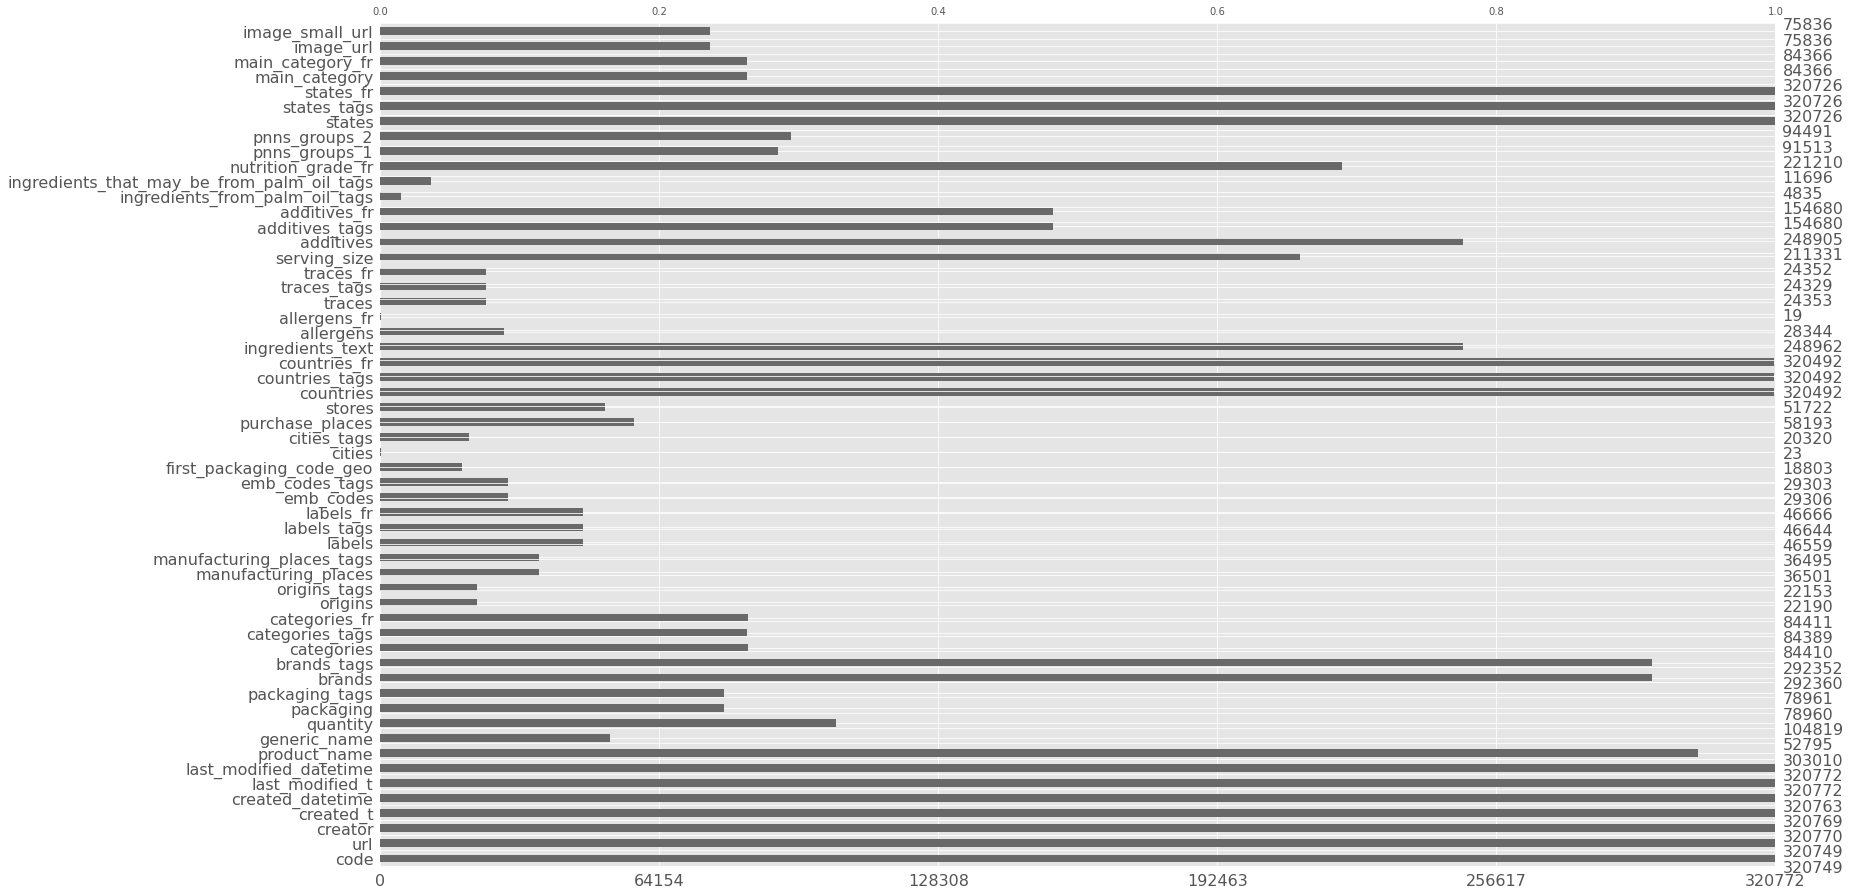

In [27]:
msn.bar(open_food_df[features_qualitatives])

<Axes: >

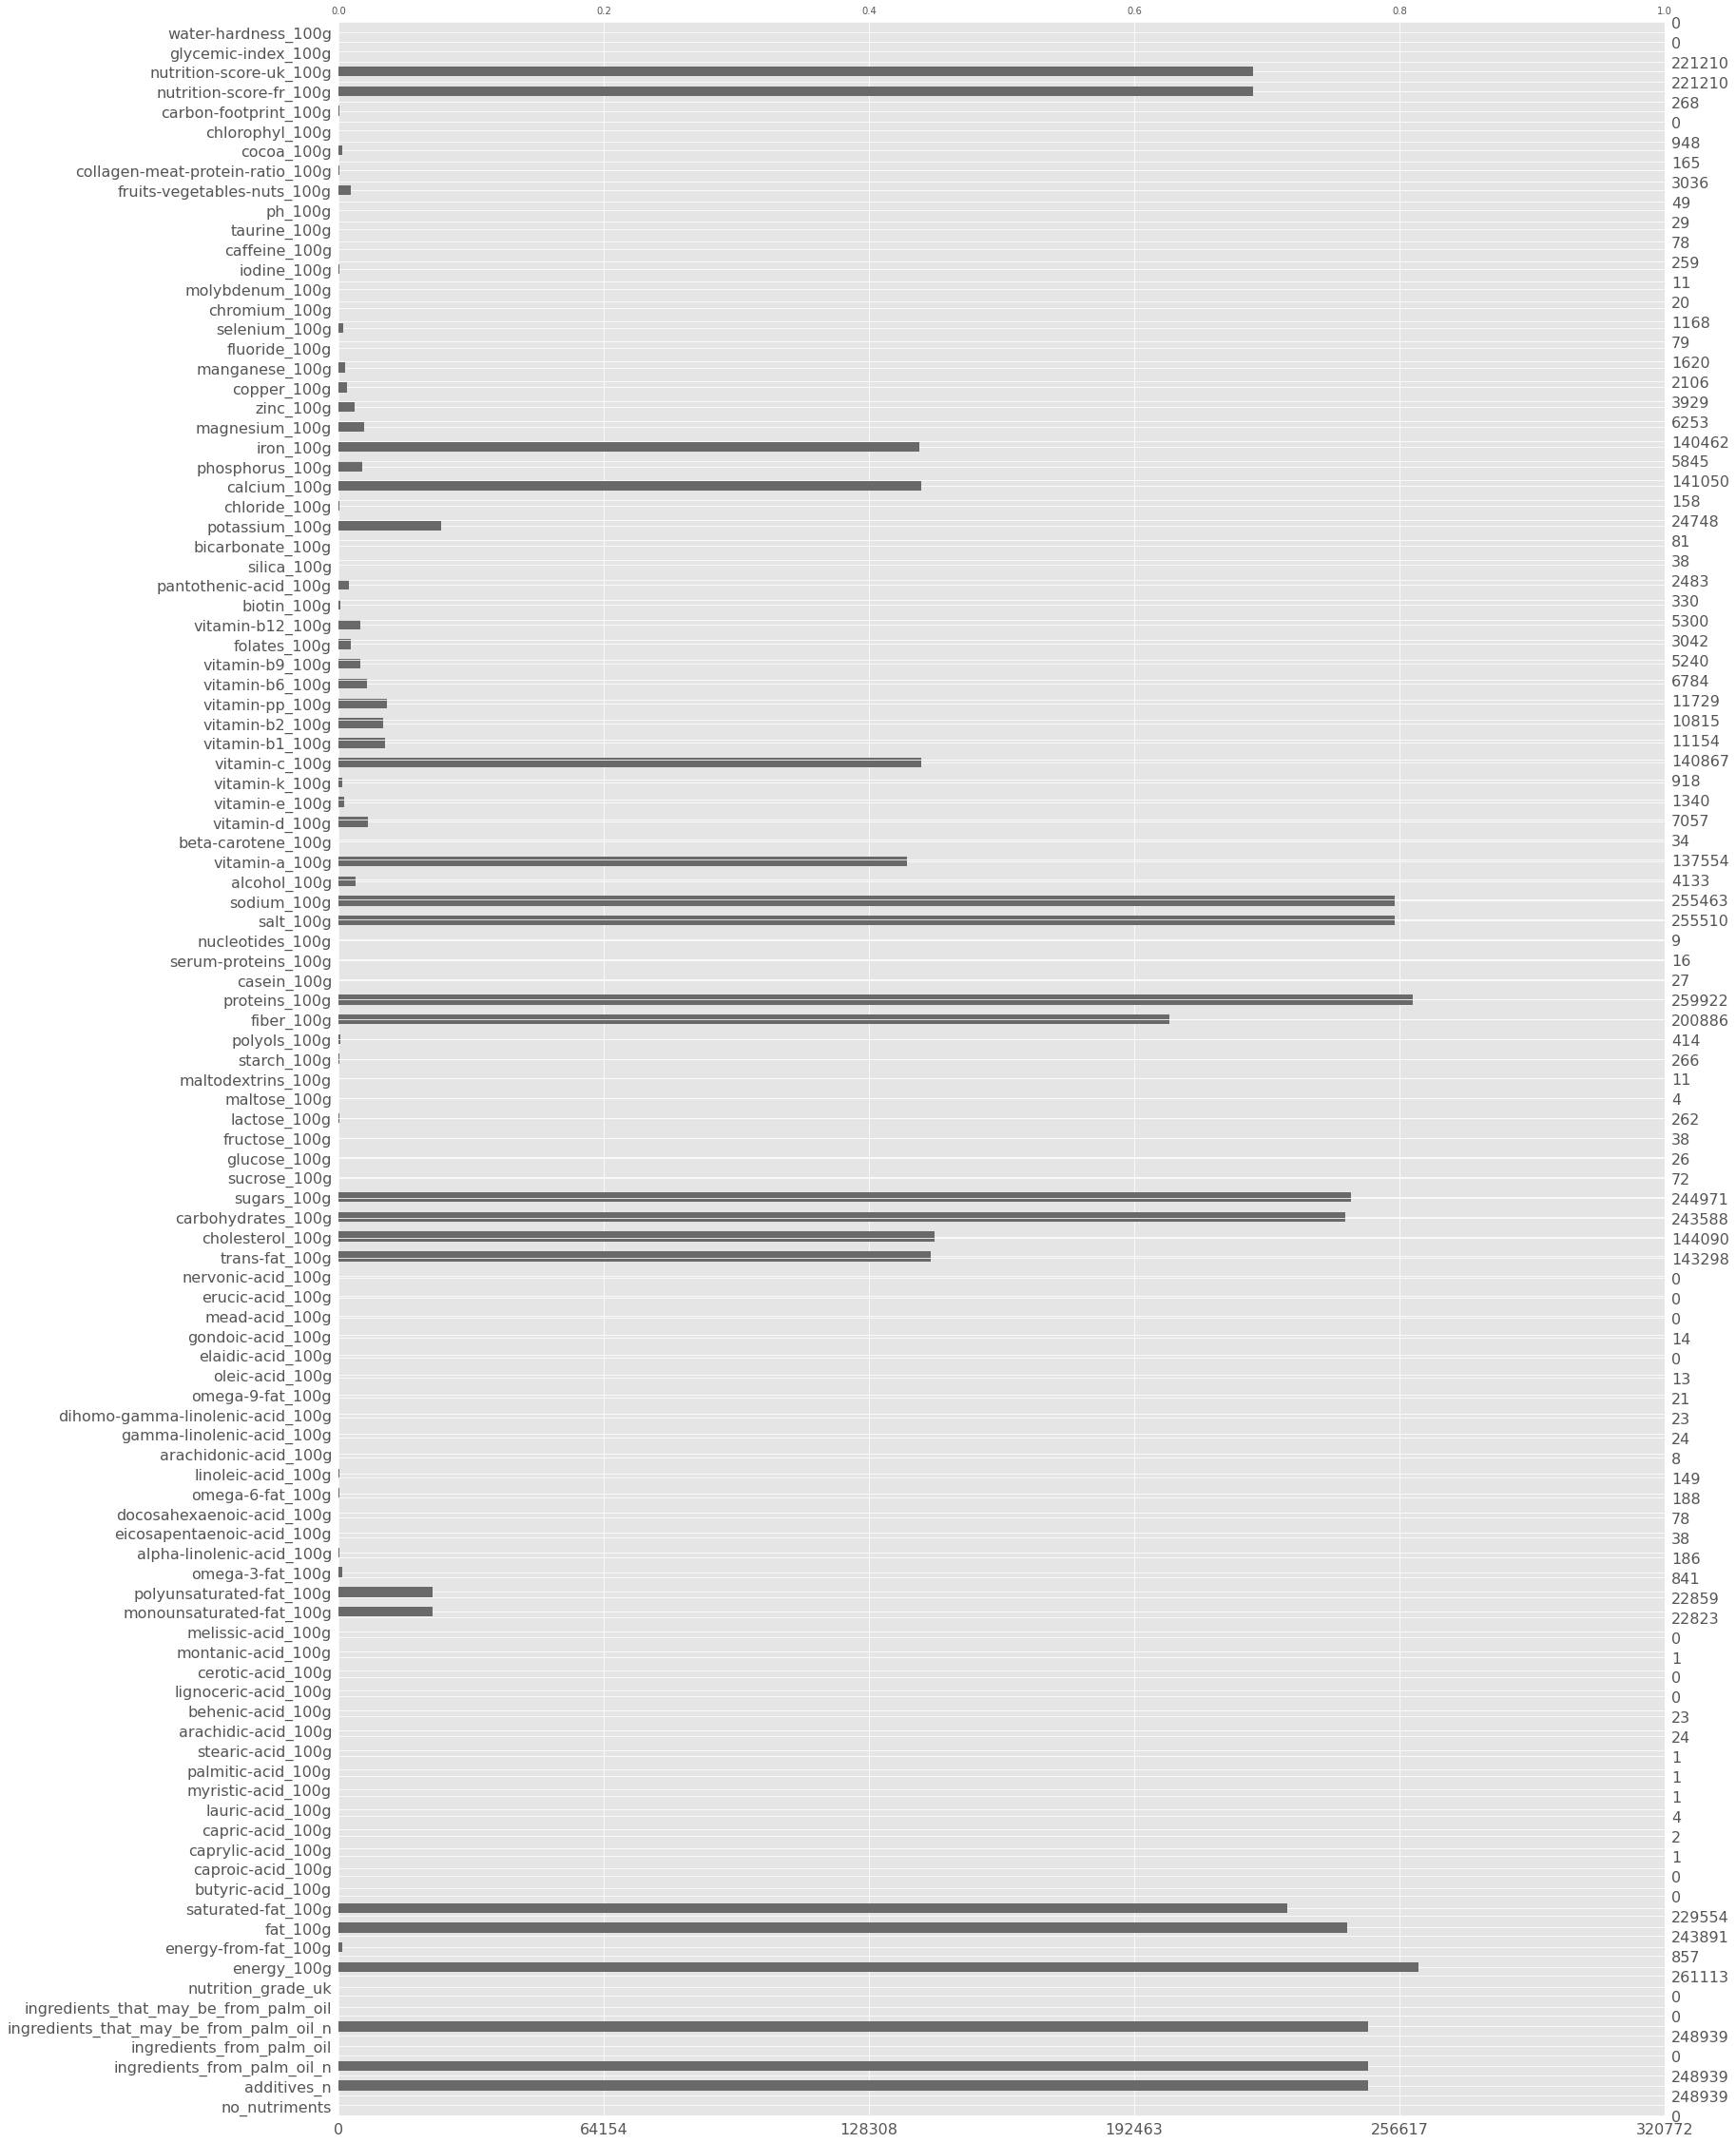

In [28]:
msn.bar(open_food_df[features_quantitatives])

cibles possibles

In [29]:
# Sélectionner les colonnes qualitatives avec plus de 50 % de valeurs manquantes
missing_data_mean = calculate_missing_data_percent(open_food_df[features_qualitatives])
missing_above_50 = missing_data_mean[missing_data_mean > 50].sort_values().index.tolist()

# Stocker toutes les colonnes ayant plus de 50 % de valeurs manquantes dans `other_missing_features`
target_candidates = missing_above_50
print(f'autres targets: {target_candidates}')

autres targets: ['additives_fr', 'additives_tags', 'quantity', 'pnns_groups_2', 'pnns_groups_1', 'categories', 'categories_tags', 'categories_fr', 'main_category_fr', 'main_category', 'packaging', 'packaging_tags', 'image_small_url', 'image_url', 'purchase_places', 'generic_name', 'stores', 'labels_fr', 'labels_tags', 'labels', 'manufacturing_places', 'manufacturing_places_tags', 'emb_codes', 'emb_codes_tags', 'allergens', 'traces_fr', 'traces', 'traces_tags', 'origins', 'origins_tags', 'cities_tags', 'first_packaging_code_geo', 'ingredients_that_may_be_from_palm_oil_tags', 'ingredients_from_palm_oil_tags', 'allergens_fr', 'cities']


In [32]:
target_candidates[0:10]

['additives_fr',
 'additives_tags',
 'quantity',
 'pnns_groups_2',
 'pnns_groups_1',
 'categories',
 'categories_tags',
 'categories_fr',
 'main_category_fr',
 'main_category']

In [ ]:
def find_target_with_min_unique_values(df, target_candidates):
    min_unique_values = np.inf
    target_to_take = None

    for target in target_candidates[0:10]:
        unique_values_count = df[target].nunique()
        if unique_values_count < min_unique_values:
            min_unique_values = unique_values_count
            target_to_take = target

    return target_to_take

# Use the function
target_to_take = find_target_with_min_unique_values(open_food_df, target_candidates)
print(target_to_take)

pnns_groups_1


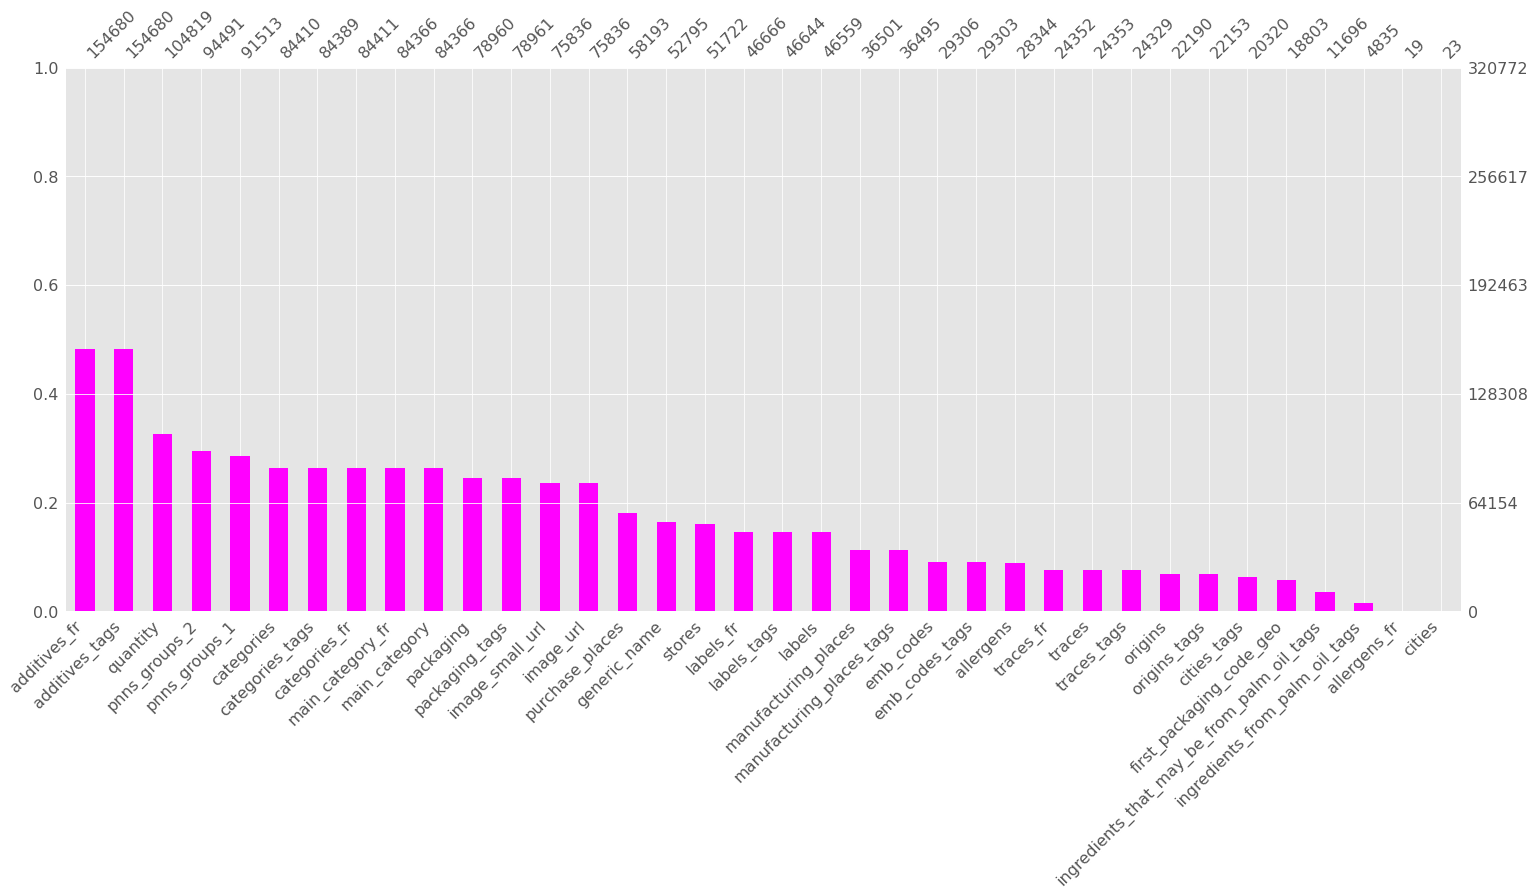

In [ ]:
msn.bar(open_food_df[target_candidates], color=(1,0,1))
plt.show()

In [ ]:
for target in target_candidates:
    print(f'Valeurs uniques pour {target} : {open_food_df[target].nunique()}')


Valeurs uniques pour additives_fr : 41537
Valeurs uniques pour additives_tags : 41537
Valeurs uniques pour quantity : 13826
Valeurs uniques pour pnns_groups_2 : 42
Valeurs uniques pour pnns_groups_1 : 14
Valeurs uniques pour categories : 36982
Valeurs uniques pour categories_tags : 21142
Valeurs uniques pour categories_fr : 21152
Valeurs uniques pour main_category_fr : 3543
Valeurs uniques pour main_category : 3543
Valeurs uniques pour packaging : 14547
Valeurs uniques pour packaging_tags : 12064
Valeurs uniques pour image_small_url : 75836
Valeurs uniques pour image_url : 75836
Valeurs uniques pour purchase_places : 5120
Valeurs uniques pour generic_name : 38584
Valeurs uniques pour stores : 3259
Valeurs uniques pour labels_fr : 13655
Valeurs uniques pour labels_tags : 13653
Valeurs uniques pour labels : 18114
Valeurs uniques pour manufacturing_places : 7308
Valeurs uniques pour manufacturing_places_tags : 6736
Valeurs uniques pour emb_codes : 8462
Valeurs uniques pour emb_codes_tags 

In [ ]:
open_food_df.pnns_groups_1.value_counts()

cities
c    9
a    8
b    6
Name: count, dtype: int64

In [18]:
# Stocker la première colonne de cette liste dans la variable `target`
target ='pnns_groups_1'
print(target)

pnns_groups_1


**Réflexion**


### Suppresion des individus sans valeur cible 

In [19]:
# delete all the lignes who doesn't have a value for the variable `target
open_food_df = open_food_df[open_food_df[target].notna()]
print(f'Nous avons {open_food_df.shape[0]} lignes après suppression des lignes sans valeur cible')


Nous avons 91513 lignes après suppression des lignes sans valeur cible


### Séparation de la cible du reste du dataset.

In [20]:
#seperate the target variable from the the dataset 
target_df= open_food_df[['code' , target]].copy().reset_index(drop=True)
subset_df = open_food_df.drop(target, axis=1)

In [21]:
target_df

code          pnns_groups_1
0      0000000024600                unknown
1      0000000036252                unknown
2      0000000039259                unknown
3      0000000039529                unknown
4      0000000290616  Fruits and vegetables
...              ...                    ...
91508  9908278636246                unknown
91509       99111250              Beverages
91510  9935010000003         Fish Meat Eggs
91511       99410148           Salty snacks
91512  9970229501521           Salty snacks

[91513 rows x 2 columns]

In [22]:
target_df.pnns_groups_1.value_counts(dropna=False)

pnns_groups_1
unknown                    22624
Sugary snacks              12368
Beverages                   9033
Milk and dairy products     8825
Cereals and potatoes        8442
Fish Meat Eggs              8041
Composite foods             6747
Fruits and vegetables       5908
Fat and sauces              5216
Salty snacks                2809
fruits-and-vegetables        987
sugary-snacks                496
cereals-and-potatoes          16
salty-snacks                   1
Name: count, dtype: int64

In [23]:
subset_df.sample(1)

code  \
266555  4388844185067   

                                                                     url  \
266555  http://world-fr.openfoodfacts.org/produit/4388844185067/rewe-bio   

       creator   created_t      created_datetime last_modified_t  \
266555   smias  1471539638  2016-08-18T17:00:38Z      1472996110   

       last_modified_datetime product_name generic_name quantity packaging  \
266555   2016-09-04T13:35:10Z          NaN          NaN   250g ℮       NaN   

       packaging_tags         brands    brands_tags  categories  \
266555            NaN  Rewe Bio,REWE  rewe-bio,rewe  Chia-Samen   

       categories_tags  categories_fr origins origins_tags  \
266555   en:chia-samen  en:Chia-samen     NaN          NaN   

       manufacturing_places manufacturing_places_tags  \
266555                  NaN                       NaN   

                                  labels  \
266555  Bio,EG-Öko-Verordnung,AT-BIO-402   

                                                               labels_tags  \
266555  en:organic,en:eu-organic,en:at-bio-402,en:bio,en:eg-oko-verordnung   

                                                      labels_fr emb_codes  \
266555  Bio,Bio européen,AT-BIO-402,en:Bio,en:Eg-oko-verordnung       NaN   

       emb_codes_tags first_packaging_code_geo cities cities_tags  \
266555            NaN                      NaN    NaN         NaN   

           purchase_places stores    countries countries_tags countries_fr  \
266555  Berlin,Deutschland   REWE  Deutschland     en:germany    Allemagne   

       ingredients_text allergens allergens_fr  \
266555              NaN       NaN          NaN   

                                                               traces  \
266555  Eier,Gluten,Milch,Senf,Sojabohnen,Schwefeldioxid und Sulphite   

                                                                              traces_tags  \
266555  en:eggs,en:gluten,en:milk,en:mustard,en:soybeans,en:sulphur-dioxide-and-sulphites   

                                                             traces_fr  \
266555  Œufs,Gluten,Lait,Moutarde,Soja,Anhydride sulfureux et sulfites   

       serving_size  no_nutriments  additives_n additives additives_tags  \
266555          NaN            NaN          NaN       NaN            NaN   

       additives_fr  ingredients_from_palm_oil_n  ingredients_from_palm_oil  \
266555          NaN                          NaN                        NaN   

       ingredients_from_palm_oil_tags  \
266555                            NaN   

        ingredients_that_may_be_from_palm_oil_n  \
266555                                      NaN   

        ingredients_that_may_be_from_palm_oil  \
266555                                    NaN   

       ingredients_that_may_be_from_palm_oil_tags  nutrition_grade_uk  \
266555                                        NaN                 NaN   

       nutrition_grade_fr pnns_groups_2  \
266555                  c       unknown   

                                                                                                     states  \
266555  en:to-be-completed, en:nutrition-facts-completed, en:ingredients-to-be-completed, en:expiration-...   

                                                                                                states_tags  \
266555  en:to-be-completed,en:nutrition-facts-completed,en:ingredients-to-be-completed,en:expiration-dat...   

                                                                                                  states_fr  \
266555  A compléter,Informations nutritionnelles complétées,Ingrédients à compléter,Date limite à complé...   

        main_category main_category_fr image_url image_small_url  energy_100g  \
266555  en:chia-samen    en:Chia-samen       NaN             NaN       1839.0   

        energy-from-fat_100g  fat_100g  saturated-fat_100g  butyric-acid_100g  \
266555                   NaN      31.1                 3.8                NaN   

        caproic-acid_100g  caprylic-a

### les taux de remplissage des features du dataset.

In [24]:
missing_data_subset  = calculate_missing_values(subset_df)
missing_data_subset

Missing Values  Missing Values (%)
water-hardness_100g           91513               100.0
erucic-acid_100g              91513               100.0
caprylic-acid_100g            91512               100.0
caproic-acid_100g             91513               100.0
elaidic-acid_100g             91513               100.0
...                             ...                 ...
created_t                         0                 0.0
states_tags                       0                 0.0
states_fr                         0                 0.0
creator                           2                 0.0
code                              0                 0.0

[161 rows x 2 columns]

<Axes: >

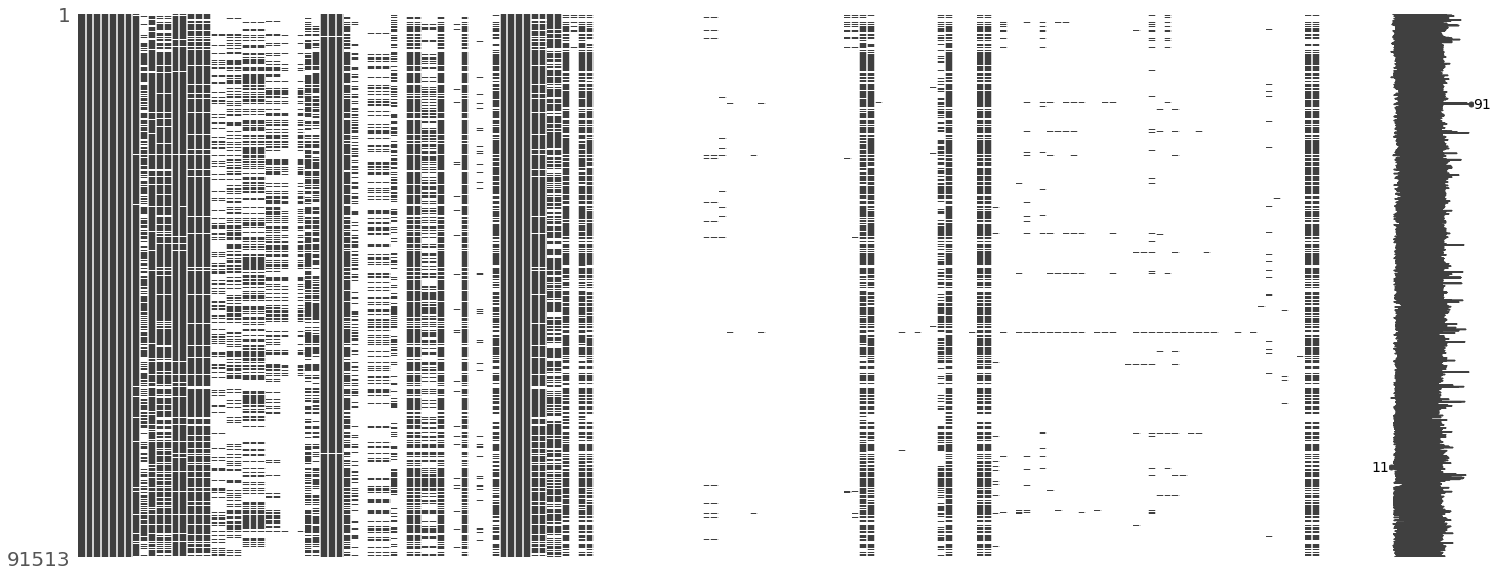

In [25]:
msn.matrix(subset_df)

### features qui sont assez remplis (plus que 50%)

In [26]:
def filter_filled_columns(df, threshold=50):
    """
    Filtre les colonnes du DataFrame pour ne conserver que celles ayant plus de `threshold` % de valeurs présentes,
    en conservant l'ordre des colonnes d'origine.

    Parameters:
        df (DataFrame): Le DataFrame contenant les données.
        threshold (float): Pourcentage minimum de valeurs présentes pour garder une colonne (par défaut : 50%).

    Returns:
        DataFrame: Un nouveau DataFrame ne contenant que les colonnes avec plus de `threshold` % de valeurs présentes.
    """
    # Calculer le pourcentage de valeurs non manquantes
    non_missing_percentage = (1 - df.isnull().mean()) * 100
    
    # Garder les colonnes ayant plus de `threshold` % de valeurs présentes
    selected_columns = non_missing_percentage[non_missing_percentage > threshold].index
    
    # Filtrer le DataFrame en conservant l'ordre d'origine
    filtered_df = df[selected_columns]
    
    return filtered_df


# Utilisation de la fonction
filtered_df = filter_filled_columns(subset_df)
filtered_df


code  \
46      0000000024600   
106     0000000036252   
136     0000000039259   
138     0000000039529   
174     0000000290616   
...               ...   
320762  9908278636246   
320763       99111250   
320765  9935010000003   
320766       99410148   
320769  9970229501521   

                                                                                                        url  \
46                                   http://world-fr.openfoodfacts.org/produit/0000000024600/filet-de-boeuf   
106                         http://world-fr.openfoodfacts.org/produit/0000000036252/lion-peanut-x2-sunridge   
136                                         http://world-fr.openfoodfacts.org/produit/0000000039259/twix-x2   
138                                  http://world-fr.openfoodfacts.org/produit/0000000039529/pack-de-2-twix   
174                 http://world-fr.openfoodfacts.org/produit/0000000290616/salade-cesar-kirkland-signature   
...                                                                                                     ...   
320762            http://world-fr.openfoodfacts.org/produit/9908278636246/szprot-w-oleju-roslinnym-evrafish   
320763                        http://world-fr.openfoodfacts.org/produit/99111250/the-vert-earl-grey-lobodis   
320765                   http://world-fr.openfoodfacts.org/produit/9935010000003/rillette-d-oie-sans-marque   
320766                                                   http://world-fr.openfoodfacts.org/produit/99410148   
320769  http://world-fr.openfoodfacts.org/produit/9970229501521/%E4%B9%90%E5%90%A7%E6%B3%A1%E8%8F%9C%E5%...   

                creator   created_t      created_datetime last_modified_t  \
46      date-limite-app  1434530704  2015-06-17T08:45:04Z      1434535914   
106             tacinte  1422221701  2015-01-25T21:35:01Z      1489055667   
136             tacinte  1422221773  2015-01-25T21:36:13Z      1473538082   
138            teolemon  1420147051  2015-01-01T21:17:31Z      1489055652   
174                  b7  1484605978  2017-01-16T22:32:58Z      1484606542   
...                 ...         ...                   ...             ...   
320762            andre  1360585770  2013-02-11T12:29:30Z      1389960647   
320763         balooval  1367163039  2013-04-28T15:30:39Z      1371690556   
320765         sebleouf  1446293229  2015-10-31T12:07:09Z      1446376839   
320766  date-limite-app  1463936572  2016-05-22T17:02:52Z      1491244498   
320769           tomato  1422099377  2015-01-24T11:36:17Z      1491244499   

       last_modified_datetime              product_name  \
46       2015-06-17T10:11:54Z             Filet de bœuf   
106      2017-03-09T10:34:27Z            Lion Peanut x2   
136      2016-09-10T20:08:02Z                   Twix x2   
138      2017-03-09T10:34:12Z            Pack de 2 Twix   
174      2017-01-16T22:42:22Z              Salade Cesar   
...                       ...                       ...   
320762   2014-01-17T12:10:47Z  Szprot w oleju roslinnym   
320763   2013-06-20T01:09:16Z        Thé vert Earl grey   
320765   2015-11-01T11:20:39Z            Rillette d'oie   
320766   2017-04-03T18:34:58Z                       NaN   
320769   2017-04-03T18:34:59Z                   乐吧泡菜味薯片   

                           generic_name  quantity     packaging  \
46                                  NaN   2.46 kg     plastique   
106                                 NaN       NaN           NaN   
136                                 NaN       NaN           NaN   
138                                 NaN       NaN           NaN   
174                    Laitue en salade  0.980 kg         Frais   
...                                 ...       ...           ...   
320762                            Sprot      170g           NaN   
320763                thé bio équitable      50 g  boîte,carton   
320765                              NaN     180 g     Pot,Verre   
320766                              NaN       NaN     Plastique   
320769  Leba

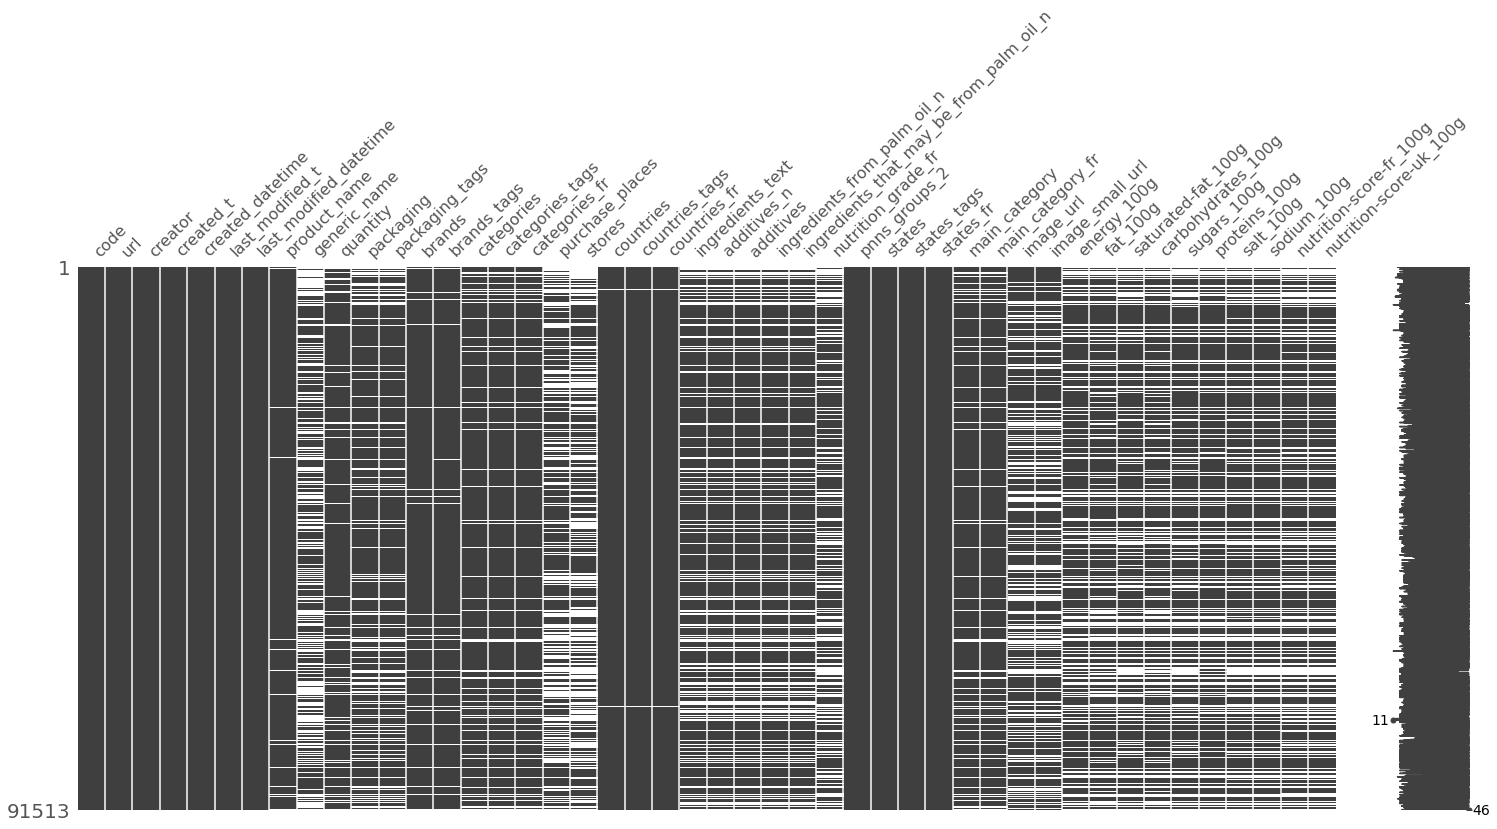

In [27]:
msn.matrix(filtered_df)
plt.show()

In [28]:
filtered_df[filtered_df.pnns_groups_2 =='Vegetables']

code  \
174     0000000290616   
236          00000758   
259          00001373   
414          00008761   
593          00040617   
...               ...   
320139  9338340000017   
320242  9346388000302   
320250  9347391000013   
320407  9415472101109   
320468  9446314213469   

                                                                                                        url  \
174                 http://world-fr.openfoodfacts.org/produit/0000000290616/salade-cesar-kirkland-signature   
236                              http://world-fr.openfoodfacts.org/produit/00000758/cauliflower-sainsbury-s   
259                            http://world-fr.openfoodfacts.org/produit/00001373/spring-onions-sainsbury-s   
414                                        http://world-fr.openfoodfacts.org/produit/00008761/spring-onions   
593                  http://world-fr.openfoodfacts.org/produit/00040617/british-iceberg-lettuce-sainsbury-s   
...                                                                                                     ...   
320139                    http://world-fr.openfoodfacts.org/produit/9338340000017/coles-fresh-garlic-4-pack   
320242           http://world-fr.openfoodfacts.org/produit/9346388000302/fresh-spinach-bunch-aussie-growers   
320250  http://world-fr.openfoodfacts.org/produit/9347391000013/cherry-tomatoes-rich-river-tomatoes-pty-ltd   
320407                      http://world-fr.openfoodfacts.org/produit/9415472101109/tomato-paste-golden-sun   
320468  http://world-fr.openfoodfacts.org/produit/9446314213469/col-rizada-kale-verdcamp-fruits-es-garantia   

            creator   created_t      created_datetime last_modified_t  \
174              b7  1484605978  2017-01-16T22:32:58Z      1484606542   
236         tacinte  1409582884  2014-09-01T14:48:04Z      1424687936   
259         tacinte  1412788478  2014-10-08T17:14:38Z      1441556289   
414            kyzh  1435064359  2015-06-23T12:59:19Z      1435066904   
593         tacinte  1470505065  2016-08-06T17:37:45Z      1470505218   
...             ...         ...                   ...             ...   
320139  foodorigins  1424660539  2015-02-23T03:02:19Z      1445661891   
320242  foodorigins  1426755234  2015-03-19T08:53:54Z      1445780735   
320250  foodorigins  1456961308  2016-03-02T23:28:28Z      1458603249   
320407       njones  1425299758  2015-03-02T12:35:58Z      1425299934   
320468      javichu  1453045243  2016-01-17T15:40:43Z      1453154498   

       last_modified_datetime                     product_name  \
174      2017-01-16T22:42:22Z                     Salade Cesar   
236      2015-02-23T10:38:56Z                      Cauliflower   
259      2015-09-06T16:18:09Z                    Spring Onions   
414      2015-06-23T13:41:44Z                    Spring onions   
593      2016-08-06T17:40:18Z          British Iceberg Lettuce   
...                       ...                              ...   
320139   2015-10-24T04:44:51Z   Coles Fresh Garlic -   4 pack    
320242   2015-10-25T13:45:35Z              Fresh Spinach Bunch   
320250   2016-03-21T23:34:09Z                  Cherry Tomatoes   
320407   2015-03-02T12:38:54Z                     Tomato Paste   
320468   2016-01-18T22:01:38Z                  Col rizada Kale   

                          generic_name  quantity        packaging  \
174                   Laitue en salade  0.980 kg            Frais   
236                        Cauliflower         1      Plastic,Bag   
259                                NaN         6     elastic band   
414                                NaN       NaN              NaN   
593                                NaN         1   plastic - film   
...                                ...       ...              ...   
320139                             NaN    4 pack  Plastic Netting   
320242                             NaN   1 Bunch          Plastic   
320250                             NaN      250g          Plastic   
320407                 

### Features intéressantes pour effectuer la prédiction

pour bien determiner les features interessantes par rapport à la prediction de la cible, il va falloir regadrer un exemple concret 

In [29]:
filtered_df.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands',
       'brands_tags', 'categories', 'categories_tags', 'categories_fr',
       'purchase_places', 'stores', 'countries', 'countries_tags',
       'countries_fr', 'ingredients_text', 'additives_n', 'additives',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'pnns_groups_2', 'states', 'states_tags', 'states_fr', 'main_category',
       'main_category_fr', 'image_url', 'image_small_url', 'energy_100g',
       'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g'],
      dtype='object')

In [30]:
# meaningful_columns = [
#     # General information
#     'code', 'product_name', 'additives_n', 
# 'additives',
# 'additives_tags',
#     # Nutri-Score
#     'nutrition_grade_fr', 'nutrition-score-fr_100g',

#     # Positive nutrition facts
#     'energy_100g', 'saturated-fat_100g', 'sugars_100g', 'salt_100g',

#     # Negative nutrition facts 
#     'fiber_100g', 'proteins_100g',
# ]
meaningful_columns =['code','product_name', 'quantity', 'packaging', 'categories_tags',
        'ingredients_text', 'additives_n',
        'nutrition_grade_fr',
       'pnns_groups_2', 'main_category', 'energy_100g',
       'fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g']
meaningful_data = filtered_df[meaningful_columns].copy()
meaningful_data.head(1)

code   product_name quantity  packaging    categories_tags  \
46  0000000024600  Filet de bœuf  2.46 kg  plastique  fr:filet-de-boeuf   

   ingredients_text  additives_n nutrition_grade_fr pnns_groups_2  \
46              NaN          NaN                NaN       unknown   

        main_category  energy_100g  fat_100g  carbohydrates_100g  sugars_100g  \
46  fr:filet-de-boeuf          NaN       NaN                 NaN          NaN   

    proteins_100g  salt_100g  sodium_100g  nutrition-score-fr_100g  
46            NaN        NaN          NaN                      NaN

<Axes: >

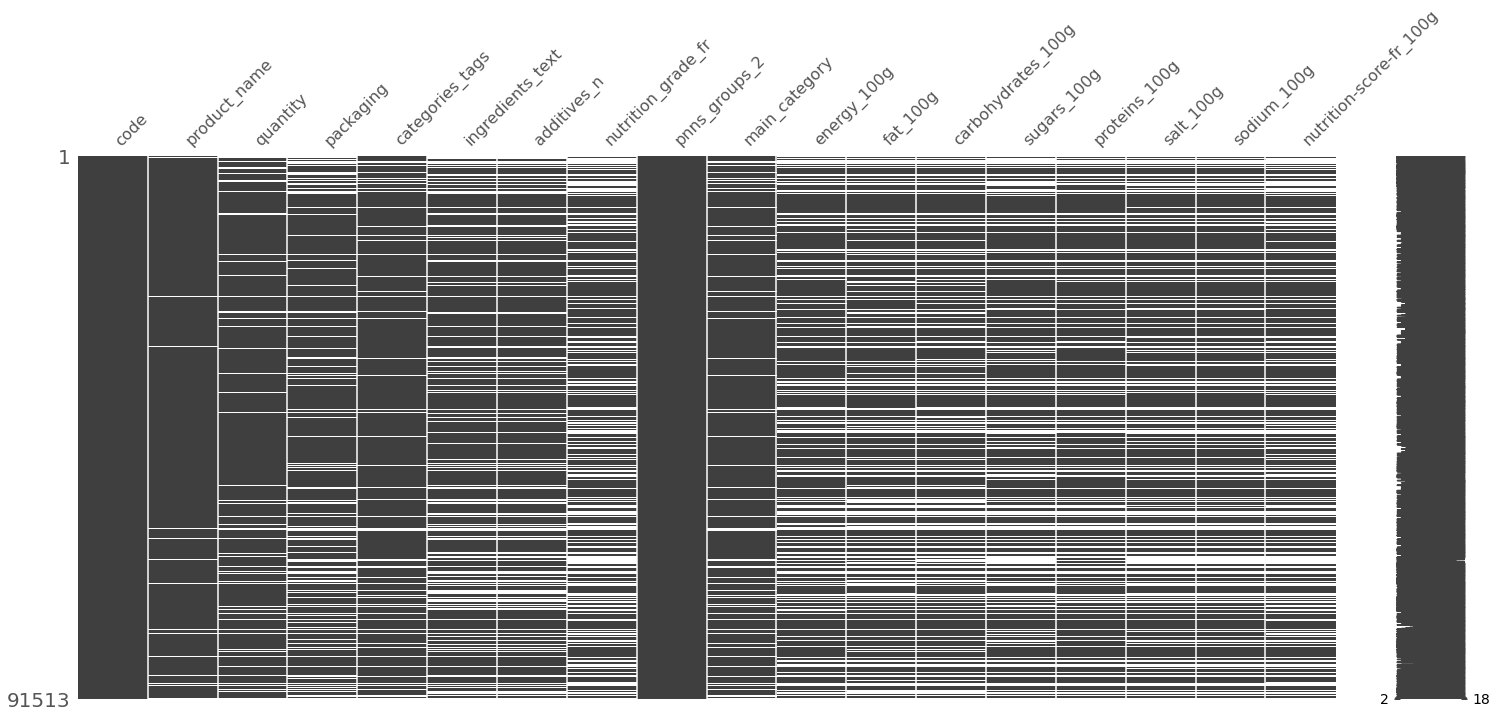

In [31]:
msn.matrix(meaningful_data)

In [32]:
meaningful_data.shape

(91513, 18)

In [33]:
df = meaningful_data.copy()

### Supprimez les produits en double.

In [34]:
df['Missing values'] = df.isna().sum(axis=1)
df = df.sort_values(by='Missing values')

In [35]:
df.loc[df.duplicated()]

Empty DataFrame
Columns: [code, product_name, quantity, packaging, categories_tags, ingredients_text, additives_n, nutrition_grade_fr, pnns_groups_2, main_category, energy_100g, fat_100g, carbohydrates_100g, sugars_100g, proteins_100g, salt_100g, sodium_100g, nutrition-score-fr_100g, Missing values]
Index: []

In [36]:
print(meaningful_columns[1:])

['product_name', 'quantity', 'packaging', 'categories_tags', 'ingredients_text', 'additives_n', 'nutrition_grade_fr', 'pnns_groups_2', 'main_category', 'energy_100g', 'fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g']


In [37]:
mask = df.duplicated(subset=meaningful_columns[1:])
mask

233026    False
252415    False
215032    False
215033    False
215034    False
          ...  
111811     True
275392     True
111820     True
111436     True
191589     True
Length: 91513, dtype: bool

In [38]:
df_unique = df.loc[~mask]
df_unique 

code  \
233026  3439495008821   
252415  3760065950029   
215032  3263850576515   
215033  3263850576614   
215034  3263850576713   
...               ...   
299742  7640159924791   
277951  5410126042474   
176353  2000000035330   
176359  2000000035336   
283569  6194043001668   

                                                                     product_name  \
233026                                                             Mousse de foie   
252415                                                  Barre noix, figue, raisin   
215032                    Biscuits petit déjeuner céréales et pépites de chocolat   
215033              Biscuits petit déjeuner Miel, céréales et pépites de chocolat   
215034  Biscuits petit déjeuner céréales et pépites de chocolat allégés en sucres   
...                                                                           ...   
299742                                                            Fortissio Lungo   
277951                                  Suzy - Gaufres de Liège au chocolat belge   
176353                                                                   Pilons 2   
176359                                            Cookie cuit au chocolat au lait   
283569                                                                        NaN   

                quantity                                         packaging  \
233026             180 g                                       Bocal,Verre   
252415              35 g                         Film plastique,Point vert   
215032             400 g                             Carton,Étui,Plastique   
215033  400 g (8 x 50 g)  Sachets plastique à jeter,Etui carton à recycler   
215034  300 g (6 x 50 g)                                    Carton,Sachets   
...                  ...                                               ...   
299742               NaN                                               NaN   
277951               NaN                                               NaN   
176353               NaN                                               NaN   
176359               NaN                                               NaN   
283569               NaN                                               NaN   

                                                                                            categories_tags  \
233026        en:meats,en:spreads,en:prepared-meats,en:salted-spreads,en:savory-mousses,fr:mousses-de-foies   
252415                                                                             en:sugary-snacks,en:bars   
215032    en:sugary-snacks,en:biscuits-and-cakes,en:biscuits,en:chocolate-biscuits,fr:biscuits-aux-cereales   
215033  en:breakfasts,en:sugary-snacks,en:biscuits-and-cakes,en:biscuits,en:chocolate-biscuits,fr:biscui...   
215034    en:sugary-snacks,en:biscuits-and-cakes,en:biscuits,en:chocolate-biscuits,fr:biscuits-aux-cereales   
...                                                                                                     ...   
299742                                                                                                  NaN   
277951                                                                                                  NaN   
176353                                                                                                  NaN   
176359                                                                                                  NaN   
283569                                                                                                  NaN   

                                                                                           ingredients_text  \
233026  Gras de porc, foie de porc 25 %, _lait_, couenne, amidon modifié, conservateur ; sel nitrité, Co...   
252415  cernaux de noix bio 33, figue bio 32%, raisin bio 31%, crème de riz bio, ostie bio (fécule de po...   
215032  Farine de _blé_ 35,5 %, sucre, pépites de chocolat 13 % [sucre, pâte de cacao, beurr

In [39]:
df_unique = df_unique.drop(columns='Missing values')

### Automate

In [ ]:
import pandas as pd
import numpy as np

def calculate_missing_data_percent(df):
    """
    Calculate the percentage of missing data for each column in the dataframe.

    Parameters:
    df (pandas.DataFrame): The input dataframe.

    Returns:
    pandas.Series: A series containing the percentage of missing values for each column.
    """
    missing_data_percent = np.round(df.isnull().mean() * 100, 2)
    return missing_data_percent

def calculate_missing_values(df):
    """
    Calculate the sum and percentage of missing values for each column in the dataframe.

    Parameters:
    df (pandas.DataFrame): The input dataframe.

    Returns:
    pandas.DataFrame: A dataframe containing the sum and percentage of missing values for each column.
    """
    missing_data_sum = df.isnull().sum()
    missing_data_percent = calculate_missing_data_percent(df)

    missing_data = pd.concat([missing_data_sum, missing_data_percent], axis=1)
    missing_data.columns = ['Missing Values', 'Missing Values (%)']
    missing_data = missing_data.sort_values(by='Missing Values (%)', ascending=False)

    return missing_data

def remove_duplicates(data, meaningful_columns):
    """
    Remove duplicate rows based on a subset of columns.

    Parameters:
    data (pandas.DataFrame): The input dataframe.
    meaningful_columns (list): A list of column names to consider for identifying duplicates.

    Returns:
    pandas.DataFrame: A dataframe with duplicate rows removed.
    """
    mask = data.duplicated(subset=meaningful_columns[1:])
    df_unique = data.loc[~mask]
    return df_unique

def find_target_with_min_unique_values(df, target_candidates):
    """
    Find the target column with the minimum number of unique values from a list of candidates.

    Parameters:
    df (pandas.DataFrame): The input dataframe.
    target_candidates (list): A list of candidate column names.

    Returns:
    str: The name of the target column with the minimum number of unique values.
    """
    min_unique_values = np.inf
    target_to_take = None
    for target in target_candidates[:10]:
        unique_values_count = df[target].nunique()
        if unique_values_count < min_unique_values:
            min_unique_values = unique_values_count
            target_to_take = target
    return target_to_take

def filter_filled_columns(df, threshold=50):
    """
    Filter columns that have a filling rate above a certain threshold.

    Parameters:
    df (pandas.DataFrame): The input dataframe.
    threshold (float): The minimum percentage of non-missing values required to keep a column.

    Returns:
    pandas.DataFrame: A dataframe containing only the columns with a filling rate above the threshold.
    """
    missing_data_percent = calculate_missing_data_percent(df)
    filtered_columns = missing_data_percent[missing_data_percent <= threshold].index
    return df[filtered_columns]

def automate_data_processing(data):
    """
    Automate the data processing pipeline.

    Parameters:
    data (pandas.DataFrame): The input dataframe.

    Returns:
    pandas.DataFrame: The processed dataframe.
    """
    qualitative_features = data.select_dtypes(exclude=['number']).columns.tolist()
    quantitative_features = data.select_dtypes(include=['number']).columns.tolist()

    missing_data_percent = calculate_missing_data_percent(data[qualitative_features])
    target_candidates = missing_data_percent[missing_data_percent > 50].sort_values().index.tolist()

    target_to_take = find_target_with_min_unique_values(data, target_candidates)

    data = data[data[target_to_take].notna()]

    target_df = data[[target_to_take]].copy().reset_index(drop=True)
    subset_df = data.drop(target_to_take, axis=1)

    missing_data = calculate_missing_data_percent(subset_df)
    print("Taux de remplissage du subset_df :")
    print(missing_data)

    filtered_df = filter_filled_columns(subset_df)
    meaningful_columns = [
        'code', 'product_name', 'quantity', 'packaging', 'categories_tags',
        'ingredients_text', 'additives_n', 'nutrition_grade_fr',
        'pnns_groups_2', 'main_category', 'energy_100g',
        'fat_100g', 'carbohydrates_100g', 'sugars_100g',
        'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g'
    ]
    meaningful_data = filtered_df[meaningful_columns].copy()

    df_final = remove_duplicates(meaningful_data, meaningful_columns)
    return df_final


# Feature Understanding

- Le but c'est :
   - identifié les valeurs aberrantes potentielles dans mon ensemble de données ;
   - automatisé l'exécution de ma stratégie pour traiter ces valeurs aberrantes de manière appropriée.


<Axes: >

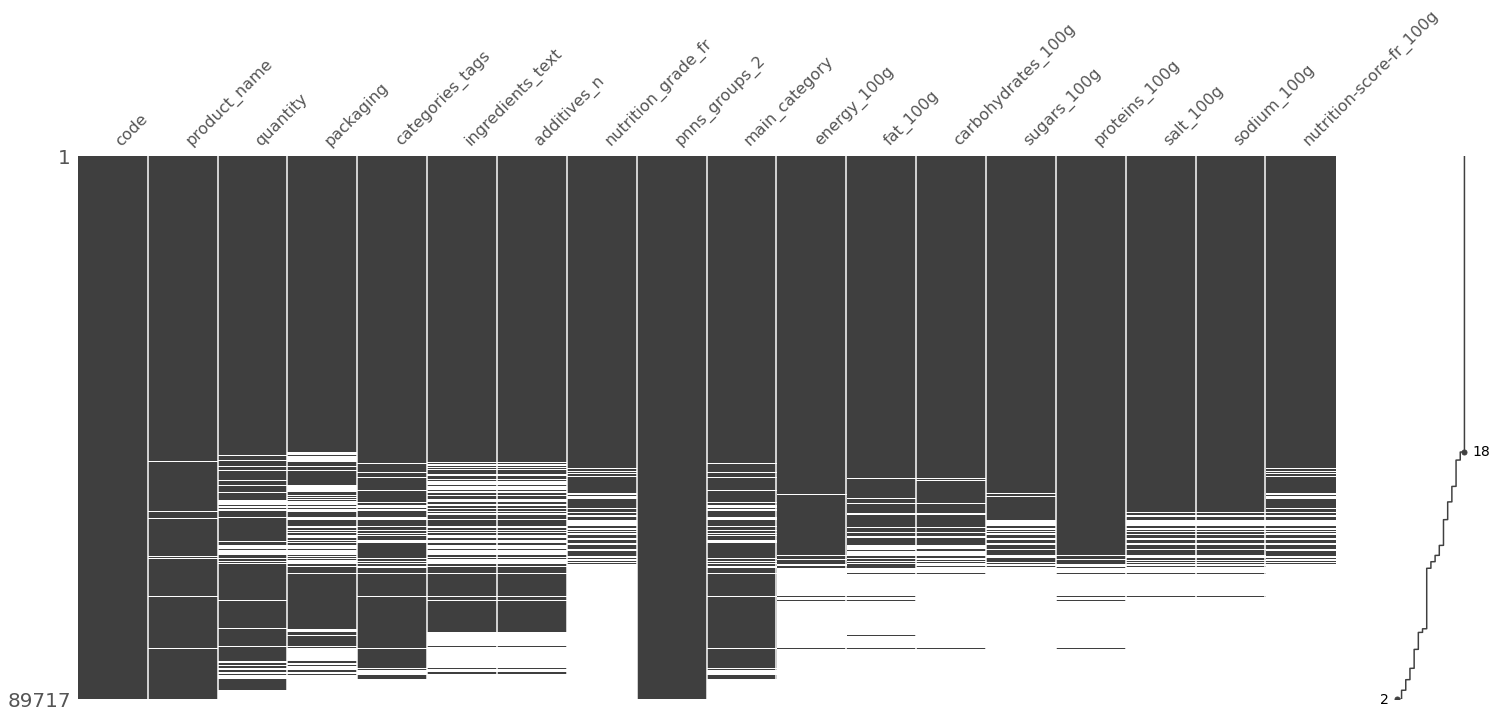

In [41]:
msn.matrix(df_unique)

## Plages interquartiles

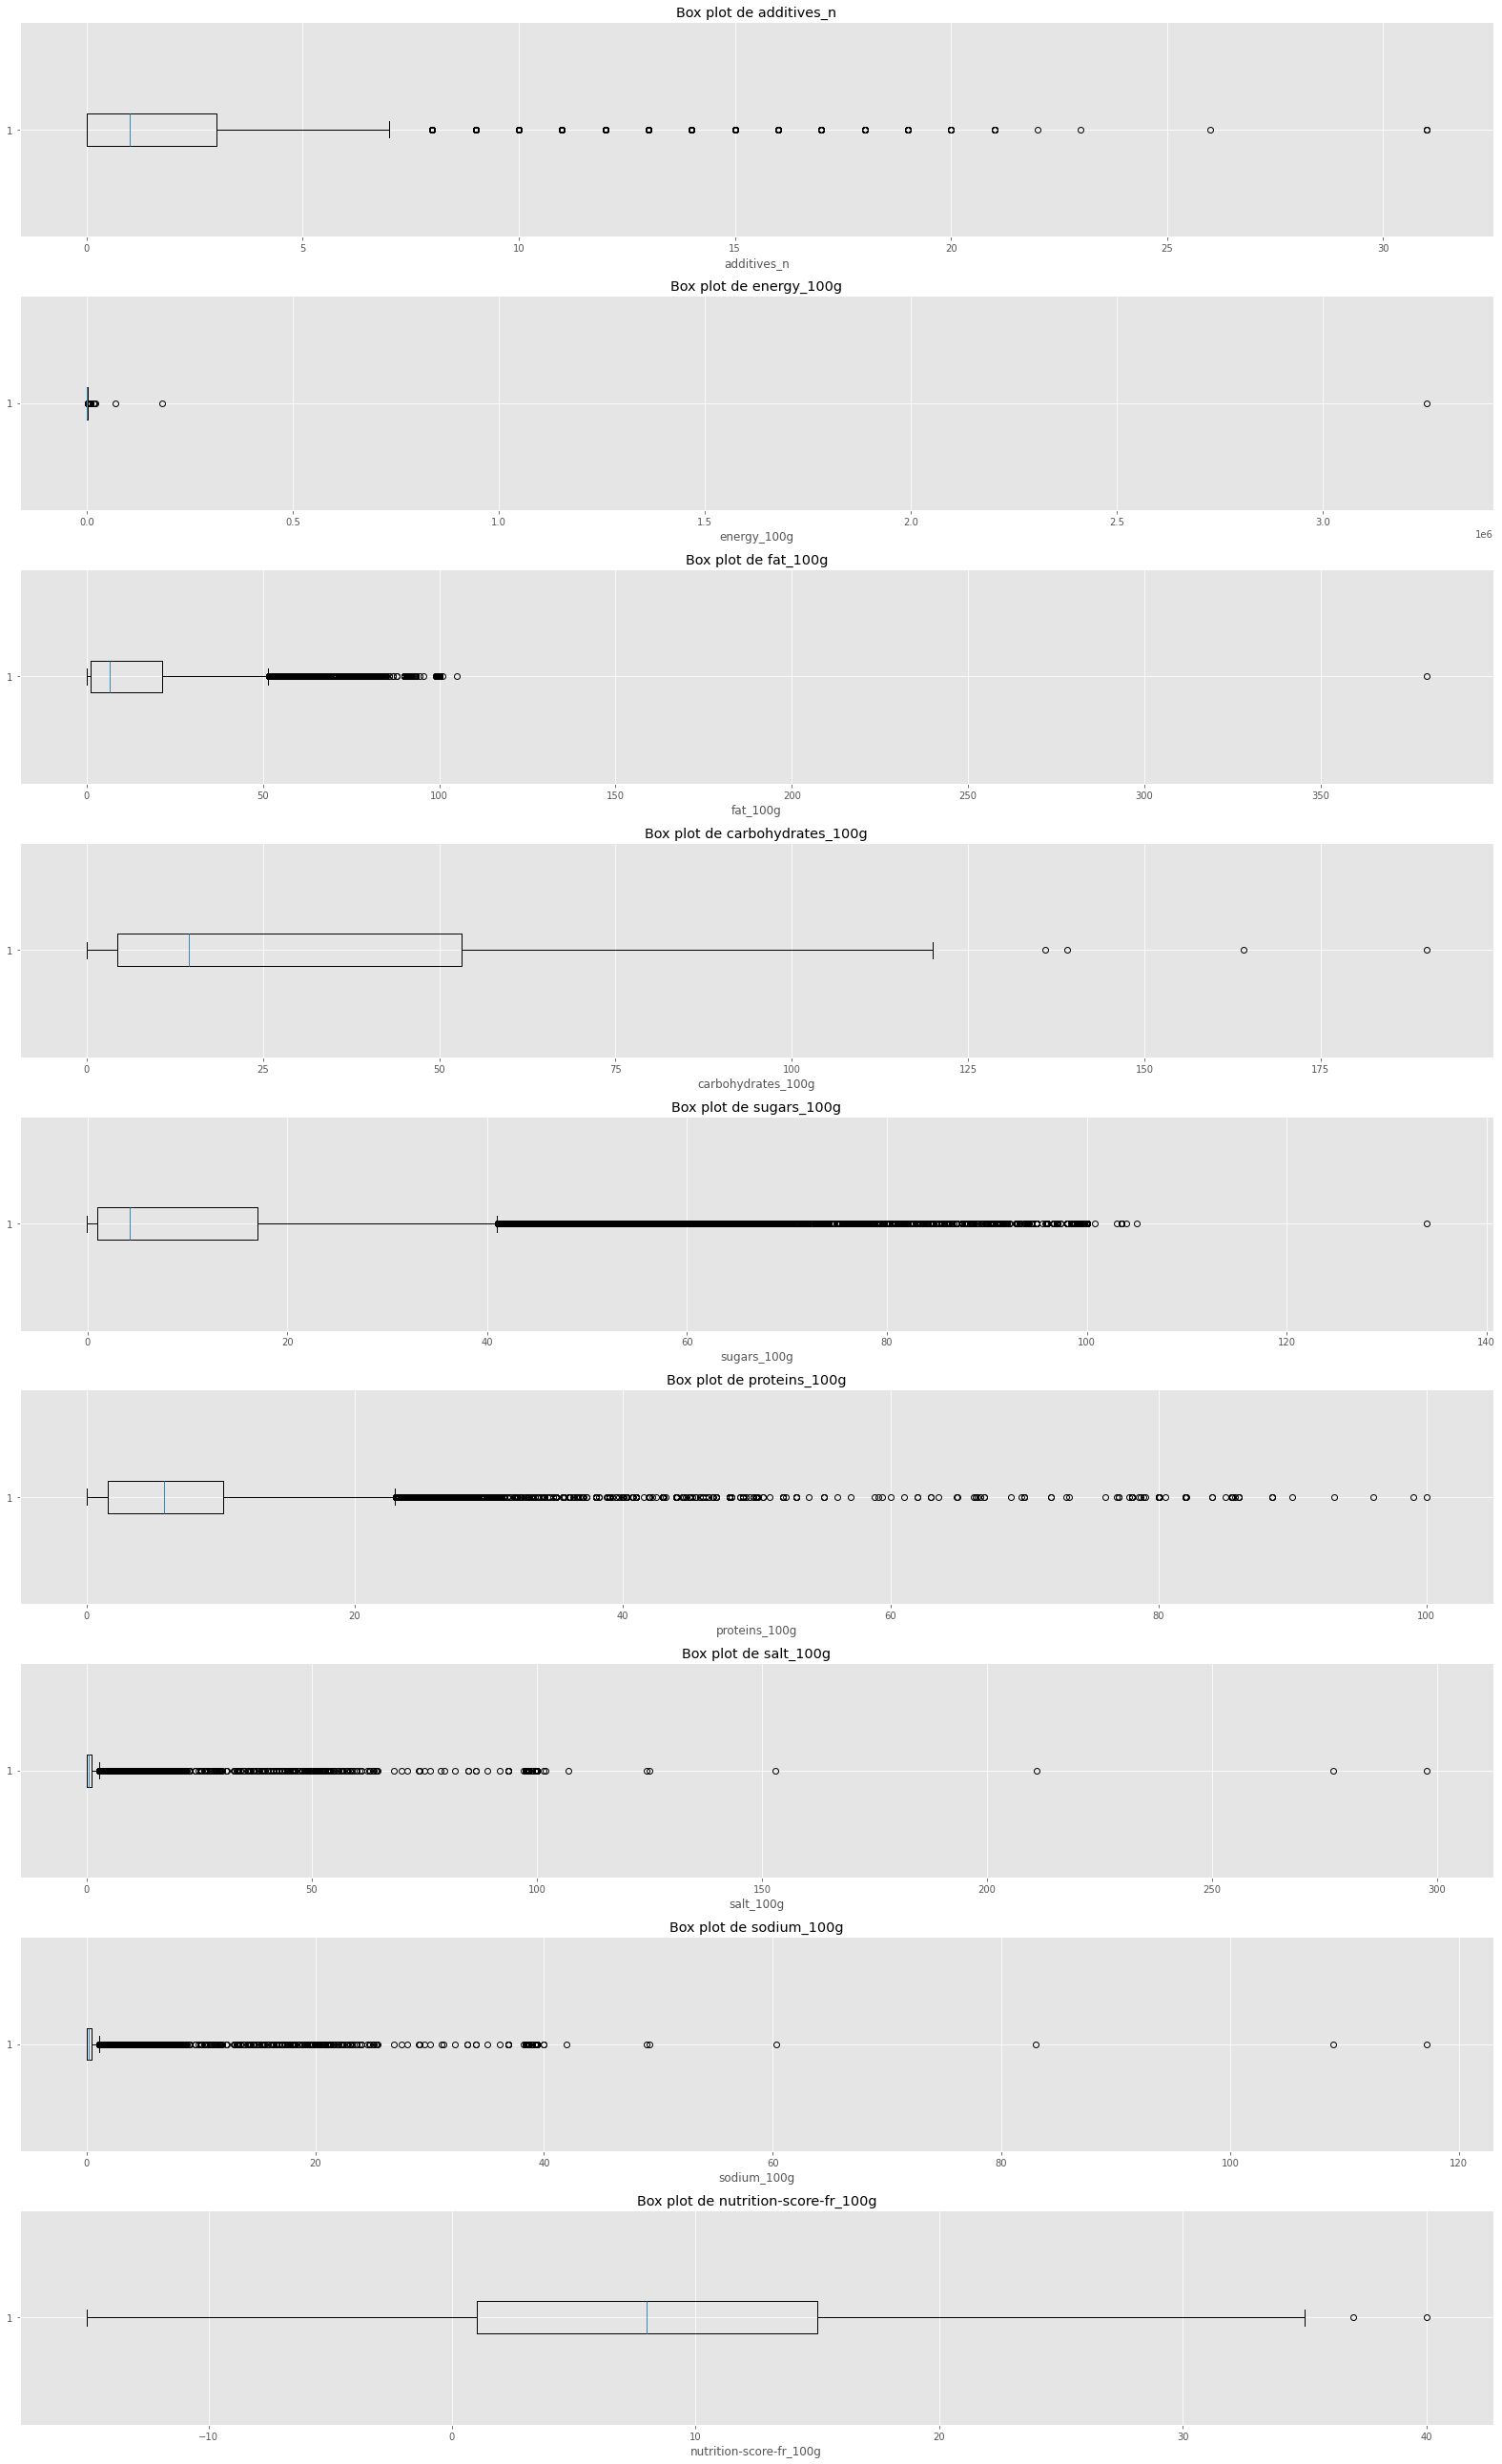

In [42]:
# get all the numeric columns from df unique
numeric_cols = df_unique.select_dtypes(include=['number']).columns.tolist()

# Créer un box plot pour chaque variable sur une figure séparée
plt.figure(figsize=(22, len(numeric_cols) * 4))  # Ajuster la taille pour l'espace nécessaire
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    plt.boxplot(df_unique[col].dropna(), vert=False)
    plt.title(f"Box plot de {col}")
    plt.xlabel(col)

plt.tight_layout()
plt.show()

- Valeurs aberantes

In [43]:
import numpy as np

outliers_dict = {}
for col in numeric_cols:
    Q1 = df_unique[col].quantile(0.25)
    Q3 = df_unique[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Détection des valeurs aberrantes avec la méthode de l'IQR
    outliers = df_unique[(df_unique[col] < Q1 - 1.5 * IQR) | (df_unique[col] > Q3 + 1.5 * IQR)]
    outliers_dict[col] = outliers[col]
    
    print(f"Variable {col} : {len(outliers)} valeurs aberrantes détectées")


Variable additives_n : 2640 valeurs aberrantes détectées
Variable energy_100g : 436 valeurs aberrantes détectées
Variable fat_100g : 2320 valeurs aberrantes détectées
Variable carbohydrates_100g : 4 valeurs aberrantes détectées
Variable sugars_100g : 6809 valeurs aberrantes détectées
Variable proteins_100g : 3094 valeurs aberrantes détectées
Variable salt_100g : 3404 valeurs aberrantes détectées
Variable sodium_100g : 3404 valeurs aberrantes détectées
Variable nutrition-score-fr_100g : 2 valeurs aberrantes détectées


In [44]:
df_unique[numeric_cols].describe()

additives_n   energy_100g      fat_100g  carbohydrates_100g  \
count  70152.000000  6.775500e+04  64332.000000        63882.000000   
mean       1.739608  1.151205e+03     13.476862           27.895316   
std        2.478274  1.253453e+04     17.354370           27.424801   
min        0.000000  0.000000e+00      0.000000            0.000000   
25%        0.000000  3.920000e+02      1.100000            4.400000   
50%        1.000000  1.009000e+03      6.500000           14.500000   
75%        3.000000  1.646000e+03     21.300000           53.200000   
max       31.000000  3.251373e+06    380.000000          190.000000   

        sugars_100g  proteins_100g     salt_100g   sodium_100g  \
count  63579.000000   67091.000000  63846.000000  63838.000000   
mean      13.237908       7.489138      1.147661      0.451883   
std       18.854404       7.617082      4.832146      1.902386   
min       -0.100000       0.000000      0.000000      0.000000   
25%        1.000000       1.600000      0.070000      0.027559   
50%        4.200000       5.800000      0.508000      0.200000   
75%       17.000000      10.200000      1.200000      0.472441   
max      134.000000     100.000000    297.600000    117.165354   

       nutrition-score-fr_100g  
count             61779.000000  
mean                  8.457890  
std                   9.103341  
min                 -15.000000  
25%                   1.000000  
50%                   8.000000  
75%                  15.000000  
max                  40.000000

on trouve qu 'ona beaucoup de valeurs aberrentes et aussi des valeurs négatif pour des veleurs de nutrition qui n'est pas normal. Nous allons traiter ces erreurs l'une apré l'autre

#### fat_100g

Recherche sur internet

In [45]:
df_unique.loc[df_unique['fat_100g']>100]

code                                product_name quantity  \
245311  3596710288755  mini choux goût fromage de chèvre - poivre     60 g   
305054  8032942610032                    Graine de couscous moyen     500g   
303101  8005305900255                    Ekstra Jomfru Olivenolie       1L   

                         packaging  \
245311  étui carton,film plastique   
305054                Boîte carton   
303101                         NaN   

                                                                                            categories_tags  \
245311                          en:salty-snacks,en:appetizers,en:crackers,fr:produits-energetiques-et-sales   
305054  en:plant-based-foods-and-beverages,en:plant-based-foods,en:cereals-and-potatoes,en:cereals-and-t...   
303101  en:plant-based-foods-and-beverages,en:plant-based-foods,en:fats,en:olive-tree-products,en:vegeta...   

                                                                                           ingredients_text  \
245311  matières grasses végétales de palme et de palmiste, œufs entiers pasteurisés, lactosérum en poud...   
305054                                                                                                  NaN   
303101                                                                                                  NaN   

        additives_n nutrition_grade_fr pnns_groups_2  \
245311          7.0                  e    Appetizers   
305054          NaN                  a       Cereals   
303101          NaN                  d          Fats   

                             main_category  energy_100g  fat_100g  \
245311                     en:salty-snacks      18700.0     380.0   
305054  en:plant-based-foods-and-beverages       1482.0     105.0   
303101                       en:olive-oils       3737.0     101.0   

        carbohydrates_100g  sugars_100g  proteins_100g  salt_100g  \
245311               190.0         22.7            0.0       9.33   
305054                70.0          2.5           12.0       0.01   
303101                 0.0          0.0            0.0       0.00   

        sodium_100g  nutrition-score-fr_100g  
245311     3.670000                     35.0  
305054     0.003937                     -1.0  
303101     0.000000                     11.0

In [46]:
df_unique.loc[df_unique['product_name']=="mini choux goût fromage de chèvre - poivre", 'fat_100g']= 54
df_unique.loc[df_unique['product_name']=="Graine de couscous moyen	", 'fat_100g']= 2
df_unique.loc[df_unique['product_name']=="mini choux goût fromage de chèvre - poivre", 'carbohydrates_100g']= 32


#### carbohydrates_100g

In [47]:
df_unique.loc[df_unique['carbohydrates_100g']>100]

code            product_name        quantity  \
234726  3473710080032       Palets pur beurre           360 g   
111566       01364008          Tomato Ketchup           567 g   
317635  8935000901649            Banane sèche           300 g   
202571  3229820787909  Sirop d'Agave brun bio  250 g / 181 ml   
260598  4016249014940        Agave Syrup dark          250 ml   
260611  4016249696122          Agavendicksaft          250 ml   
265108  4305615344508          Agavendicksaft             NaN   
260599  4016249015732       Sirop d agave pur             NaN   
265110  4305615359281   Agavendicksaft Dunkel           250ml   
239347  3560070740338           Sirop d'agave          250 ml   
315621  8718309253745                     NaN          375 ml   
73668   0070896329158       Icing Decorations             NaN   
155609  0838619000254         Beurre d'érable           245 g   

                       packaging  \
234726           Plastique,Métal   
111566                    Bottle   
317635  barquette,Film,plastique   
202571          Flacon,Plastique   
260598                Kunststoff   
260611                      Glas   
265108                       NaN   
260599                       NaN   
265110                       PET   
239347   Flacon,Plastique,flacon   
315621                       NaN   
73668                        NaN   
155609                       NaN   

                                                                                            categories_tags  \
234726                                                   en:sugary-snacks,en:biscuits-and-cakes,en:biscuits   
111566                                                   en:groceries,en:sauces,en:tomato-sauces,en:ketchup   
317635  en:plant-based-foods-and-beverages,en:plant-based-foods,en:fruits-and-vegetables-based-foods,en:...   
202571                                             en:sweeteners,en:syrups,en:simple-syrups,en:agave-syrups   
260598                                             en:sweeteners,en:syrups,en:simple-syrups,en:agave-syrups   
260611                                             en:sweeteners,en:syrups,en:simple-syrups,en:agave-syrups   
265108                                             en:sweeteners,en:syrups,en:simple-syrups,en:agave-syrups   
260599                                             en:sweeteners,en:syrups,en:simple-syrups,en:agave-syrups   
265110                                             en:sweeteners,en:syrups,en:simple-syrups,en:agave-syrups   
239347  en:spreads,en:breakfasts,en:sweet-spreads,en:sweeteners,en:syrups,en:simple-syrups,en:agave-syru...   
315621                                                                                                  NaN   
73668                                                                                                   NaN   
155609                                                                                                  NaN   

                                                                                           ingredients_text  \
234726  Farine de _blé_, beurre frais de baratte (_lait_), 36% sucre, jaunes d'_oeufs_, sel de Guérande,...   
111566  Tomato concentrate from red ripe tomatoes, distilled vinegar, high fructose corn syrup, corn syr...   
317635                                                                                               banane   
202571                                                                                  100% sirop d'agave.   
260598                                                                            konzentrierter Agavensaft   
260611                                                                           Konzentrierter Agavensaft.   
265108                                                                            konzentrierter Agavensaft   
260599                                                                                                  NaN   
265110                                         

In [48]:
df_unique.loc[df_unique['product_name']=="Palets pur beurre", 'carbohydrates_100g'] = 65.0
df_unique.loc[df_unique['product_name']=="Toaster Pastries, Strawberry", 'carbohydrates_100g'] = 75.0
# drop the line where the product name equal Mango 
df_unique.drop(df_unique[df_unique['product_name'] == "Mango Jalapeno"].index, inplace=True)

#### sugars_100g

In [49]:
df_unique.loc[df_unique['sugars_100g']<0]

code       product_name quantity      packaging  \
195761  3161712000928  Caprice des dieux     300g  Carton,carton   

                             categories_tags  \
195761  en:dairies,en:cheeses,en:cow-cheeses   

                                          ingredients_text  additives_n  \
195761  _Lait_ de vache, _crème_, sel, ferments lactiques.          0.0   

       nutrition_grade_fr pnns_groups_2   main_category  energy_100g  \
195761                  d        Cheese  en:cow-cheeses       1379.0   

        fat_100g  carbohydrates_100g  sugars_100g  proteins_100g  salt_100g  \
195761      30.0                 0.8         -0.1           15.3        1.4   

        sodium_100g  nutrition-score-fr_100g  
195761     0.551181                     15.0

In [50]:
df_unique.loc[df_unique['product_name']=="Hummous, Black Truffle", 'sugars_100g'] = 0
df_unique.loc[df_unique['product_name']=="Caprice des dieux", 'sugars_100g'] = 0
df_unique.loc[df_unique['product_name']=="Crackers", 'sugars_100g'] = 8
df_unique.loc[df_unique['product_name'] == "Nusco, Chocolate Spread, Chocolate", 
              ['sugars_100g', 'carbohydrates_100g', 'fat_100g', 'proteins_100g', 'fiber_100g']] = [30.0, 34.0, 43.0, 7.6, 9.3]


#### Salt

In [51]:
df_unique.loc[df_unique['salt_100g']>100]

code                                  product_name  \
232239  3423720002432                                     Keeny Bio   
233372  3445850070259                   Sel de Guérande Label Rouge   
274767  5060224881163                                 Cheese salad    
176694  2000000045416                                         flake   
176696  2000000045488                                     herdhey's   
21632   0024600017008                            Coarse Kosher Salt   
109154  0096619911936                           Himalayan Pink Salt   
32371   0036632038258            Light & Fit Greek Crunch - S'mores   
40408   0041224708006  Fleur De Sel, Hand-Harvested French Sea Salt   

             quantity          packaging  \
232239          135 g  Paquet individuel   
233372          125 g             Carton   
274767            NaN       plastic film   
176694            18g            plastic   
176696            40g            plastic   
21632           48 oz        Card,Carton   
109154  13 oz (368.5)                NaN   
32371      5oz (141g)                NaN   
40408             NaN                NaN   

                                                                                            categories_tags  \
232239                                          en:sugary-snacks,en:biscuits-and-cakes,en:desserts,en:cakes   
233372                                   en:groceries,en:condiments,en:salts,en:sea-salts,en:guerande-salts   
274767                                                                                        en:sandwiches   
176694                                                                       en:sugary-snacks,en:chocolates   
176696                                                                                 en:cookies-chocolate   
21632                                                                   en:groceries,en:condiments,en:salts   
109154  en:plant-based-foods-and-beverages,en:plant-based-foods,en:groceries,en:condiments,en:spices,en:...   
32371                                                                                                   NaN   
40408                                                      en:groceries,en:condiments,en:salts,en:sea-salts   

                                                                                           ingredients_text  \
232239  Farine de _blé_ T65*, _Œufs_ entiers*, sucre de canne roux non raffinement*, huile de tournesol ...   
233372                                                                                     Sel marin moulu.   
274767  torpido 69% (_Wheat_ flour, water, salt, yeast, vegetable fat, _soya_ flour, ascorbic acid, _ses...   
176694                                                                                                  NaN   
176696                                                                                                  NaN   
21632                                                  Salt, Yellow Prussiate of Soda (Anti-caking agent)     
109154                                                                                  Himalayan Pink Salt   
32371                                                                                                   NaN   
40408                                                      Sea salt hand-harvested from france's ile de re.   

        additives_n nutrition_grade_fr       pnns_groups_2  \
232239          4.0                  e  Biscuits and cakes   
233372          0.0                  c             unknown   
274767          1.0                  d            Sandwich   
176694          NaN                  e  Chocolate products   
176696          NaN                  d             unknown   
21632           1.0                NaN             unknown   
109154          0.0                NaN             unknown   
32371           NaN                  d             unknown   
40408           0.0                NaN             unknown   

               main_ca

#### nutrition-score-fr_100g


In [52]:
df_unique.loc[df_unique['nutrition-score-fr_100g']<0].shape

(11028, 19)

## Traitement des outliers

In [53]:
df_unique.describe()

additives_n   energy_100g      fat_100g  carbohydrates_100g  \
count  70152.000000  6.775500e+04  64332.000000        63882.000000   
mean       1.739608  1.151205e+03     13.471794           27.892201   
std        2.478274  1.253453e+04     17.294837           27.415957   
min        0.000000  0.000000e+00      0.000000            0.000000   
25%        0.000000  3.920000e+02      1.100000            4.400000   
50%        1.000000  1.009000e+03      6.500000           14.500000   
75%        3.000000  1.646000e+03     21.300000           53.200000   
max       31.000000  3.251373e+06    105.000000          164.000000   

        sugars_100g  proteins_100g     salt_100g   sodium_100g  \
count  63581.000000   67091.000000  63846.000000  63838.000000   
mean      13.237212       7.489138      1.147661      0.451883   
std       18.853242       7.617082      4.832146      1.902386   
min        0.000000       0.000000      0.000000      0.000000   
25%        1.000000       1.600000      0.070000      0.027559   
50%        4.200000       5.800000      0.508000      0.200000   
75%       17.000000      10.200000      1.200000      0.472441   
max      134.000000     100.000000    297.600000    117.165354   

       nutrition-score-fr_100g  fiber_100g  
count             61779.000000         0.0  
mean                  8.457890         NaN  
std                   9.103341         NaN  
min                 -15.000000         NaN  
25%                   1.000000         NaN  
50%                   8.000000         NaN  
75%                  15.000000         NaN  
max                  40.000000         NaN

Avant de traiter les valeurs abberantes, on doit decider commenr nous allons classifier nos produits, un exemple : si on a un bonbon avec une valeur aberante pour la valeur de protein dans 100g qui est de 30g sachant que notre moyenne de protein pour tout les produits est est de 7.3g, si nous attribuons cette valeur au bonbon c'est une valeur erronée et meme pas approximative . Une solution pour ce probléme est de clasiffier ces produits par categories, exmple (prduit laitier , viandes, etc ... ), mais puisque nous n'avons pas de variable qui nous permet de faire ça :
- Nous utiliserons le regroupement par le grade de nutrition des produits de grade b ont souvent le memes ou preseque les memes valeurs . 
  

In [54]:
# groub the df unique bt nutrition grade and calculate the mean of each column 
nutritional_columns = ['additives_n','energy_100g',	'fat_100g',	'carbohydrates_100g','sugars_100g',	'proteins_100g','salt_100g','sodium_100g','nutrition-score-fr_100g','fiber_100g']
grouped_byGrade = df_unique.groupby('nutrition_grade_fr')[nutritional_columns].mean()
grouped_byGrade.reset_index()

nutrition_grade_fr  additives_n  energy_100g   fat_100g  carbohydrates_100g  \
0                  a     0.813431   696.301652   2.779515           26.338585   
1                  b     1.791182   923.154428   4.190536           18.028913   
2                  c     1.985176   870.803907   9.280208           23.531465   
3                  d     2.335921  1435.724922  19.963916           30.904427   
4                  e     2.349620  1744.110595  26.335107           37.846146   

   sugars_100g  proteins_100g  salt_100g  sodium_100g  \
0     3.942690       7.489295   0.335874     0.132234   
1     4.807841       5.997154   0.557112     0.219336   
2     9.723914       6.817771   1.378877     0.542862   
3    16.822827       9.167755   1.443530     0.568327   
4    26.491175       6.951677   1.105794     0.435344   

   nutrition-score-fr_100g  fiber_100g  
0                -3.771176         NaN  
1                 0.860341         NaN  
2                 5.708393         NaN  
3                13.760590         NaN  
4                21.213169         NaN

In [55]:
print(grouped_byGrade.index)
print(grouped_byGrade.columns)

Index(['a', 'b', 'c', 'd', 'e'], dtype='object', name='nutrition_grade_fr')
Index(['additives_n', 'energy_100g', 'fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
       'nutrition-score-fr_100g', 'fiber_100g'],
      dtype='object')


In [56]:
# slect row with no nutrition grade 
no_grade_df = df_unique[df_unique['nutrition_grade_fr'].isnull()]
no_grade_df

code                                   product_name  \
242846  3564700719794                              Velouté de Bolets   
185015       26043852  Pur jus de clémentine, orange et raisin blanc   
313839  8711200575961   Cup a Soup Big Break Tagliatelle Champignons   
264174       42280859                                Bio Gemüsebrühe   
195892  3162080201146                                    Bonne purée   
...               ...                                            ...   
299742  7640159924791                                Fortissio Lungo   
277951  5410126042474      Suzy - Gaufres de Liège au chocolat belge   
176353  2000000035330                                       Pilons 2   
176359  2000000035336                Cookie cuit au chocolat au lait   
283569  6194043001668                                            NaN   

             quantity              packaging  \
242846  66 g (4 bols)  Sachet papier à jeter   
185015            1 L    Bouteille plastique   
313839       2 * 35 g         Carton,Sachets   
264174          165 g                   Glas   
195892           500g         sachets,carton   
...               ...                    ...   
299742            NaN                    NaN   
277951            NaN                    NaN   
176353            NaN                    NaN   
176359            NaN                    NaN   
283569            NaN                    NaN   

                                                                                            categories_tags  \
242846  en:dried-products,en:meals,en:dried-products-to-be-rehydrated,en:soups,en:dried-meals,en:dehydra...   
185015  en:plant-based-foods-and-beverages,en:beverages,en:plant-based-beverages,en:fruit-based-beverage...   
313839  en:dried-products,en:meals,en:dried-products-to-be-rehydrated,en:soups,en:dried-meals,en:dehydra...   
264174  en:plant-based-foods-and-beverages,en:plant-based-foods,en:groceries,en:dried-products,en:broths...   
195892                      en:dried-products,en:dried-products-to-be-rehydrated,en:instant-mashed-potatoes   
...                                                                                                     ...   
299742                                                                                                  NaN   
277951                                                                                                  NaN   
176353                                                                                                  NaN   
176359                                                                                                  NaN   
283569                                                                                                  NaN   

                                                                                           ingredients_text  \
242846  Farine de _blé_, fécule de pomme de terre, sel, bolet 3,6 %, sucre, huile de colza, arôme nature...   
185015                                                             jus de clémentine, orange, raisin blanc,   
313839  Tagliatelle 43% (pâte : semoule de _blé_ dur, sel), amidon de pomme de terre, graisse de palme, ...   
264174  Meersalz, Maltodextrin, Zwiebeln, Rohrohrzucker, Karotten, Maisstärke, Sonnenblumenöl, Lauch, Pe...   
195892  Pommes de terre 99%, émulsifiant : mono- et diglycérides d'acides gras, curcuma, antioxydants : ...   
...                                                                                                     ...   
299742                                                                                                  NaN   
277951                                                                                                  NaN   
176353                                                                                                  NaN   
176359                                                                                                  NaN   
283569               

In [ ]:
# Example function to identify outliers (you may use your own method)
def is_outlier(series, threshold=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return (series < (Q1 - threshold * IQR)) | (series > (Q3 + threshold * IQR))

# Loop through each column where you want to replace outliers
columns_to_check = ['fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'nutrition-score-fr_100g']

for col in columns_to_check:
    # Identify outliers in the main DataFrame for the column
    outliers = is_outlier(df_unique[col])

    # Replace each outlier with the mean for its respective grade, if grade is not NaN
    df_unique.loc[outliers & df_unique['nutrition_grade_fr'].notna(), col] = df_unique.loc[outliers & df_unique['nutrition_grade_fr'].notna()].apply(
        lambda row: grouped_byGrade.loc[row['nutrition_grade_fr'], col], axis=1
    )



In [58]:
df_unique.describe()

additives_n   energy_100g      fat_100g  carbohydrates_100g  \
count  70152.000000  6.775500e+04  64332.000000        63882.000000   
mean       1.739608  1.151205e+03     11.770582           27.888748   
std        2.478274  1.253453e+04     13.154498           27.409103   
min        0.000000  0.000000e+00      0.000000            0.000000   
25%        0.000000  3.920000e+02      1.100000            4.400000   
50%        1.000000  1.009000e+03      6.500000           14.500000   
75%        3.000000  1.646000e+03     20.000000           53.200000   
max       31.000000  3.251373e+06    100.000000          164.000000   

        sugars_100g  proteins_100g     salt_100g   sodium_100g  \
count  63581.000000   67091.000000  63846.000000  63838.000000   
mean       9.464355       6.628655      0.804274      0.451883   
std       11.282525       5.966494      2.662956      1.902386   
min        0.000000       0.000000      0.000000      0.000000   
25%        1.000000       1.600000      0.070000      0.027559   
50%        4.200000       5.800000      0.508000      0.200000   
75%       15.400000       9.167755      1.190000      0.472441   
max      105.000000      88.500000    107.000000    117.165354   

       nutrition-score-fr_100g  fiber_100g  
count             61779.000000         0.0  
mean                  8.457331         NaN  
std                   9.102021         NaN  
min                 -15.000000         NaN  
25%                   1.000000         NaN  
50%                   8.000000         NaN  
75%                  15.000000         NaN  
max                  35.000000         NaN

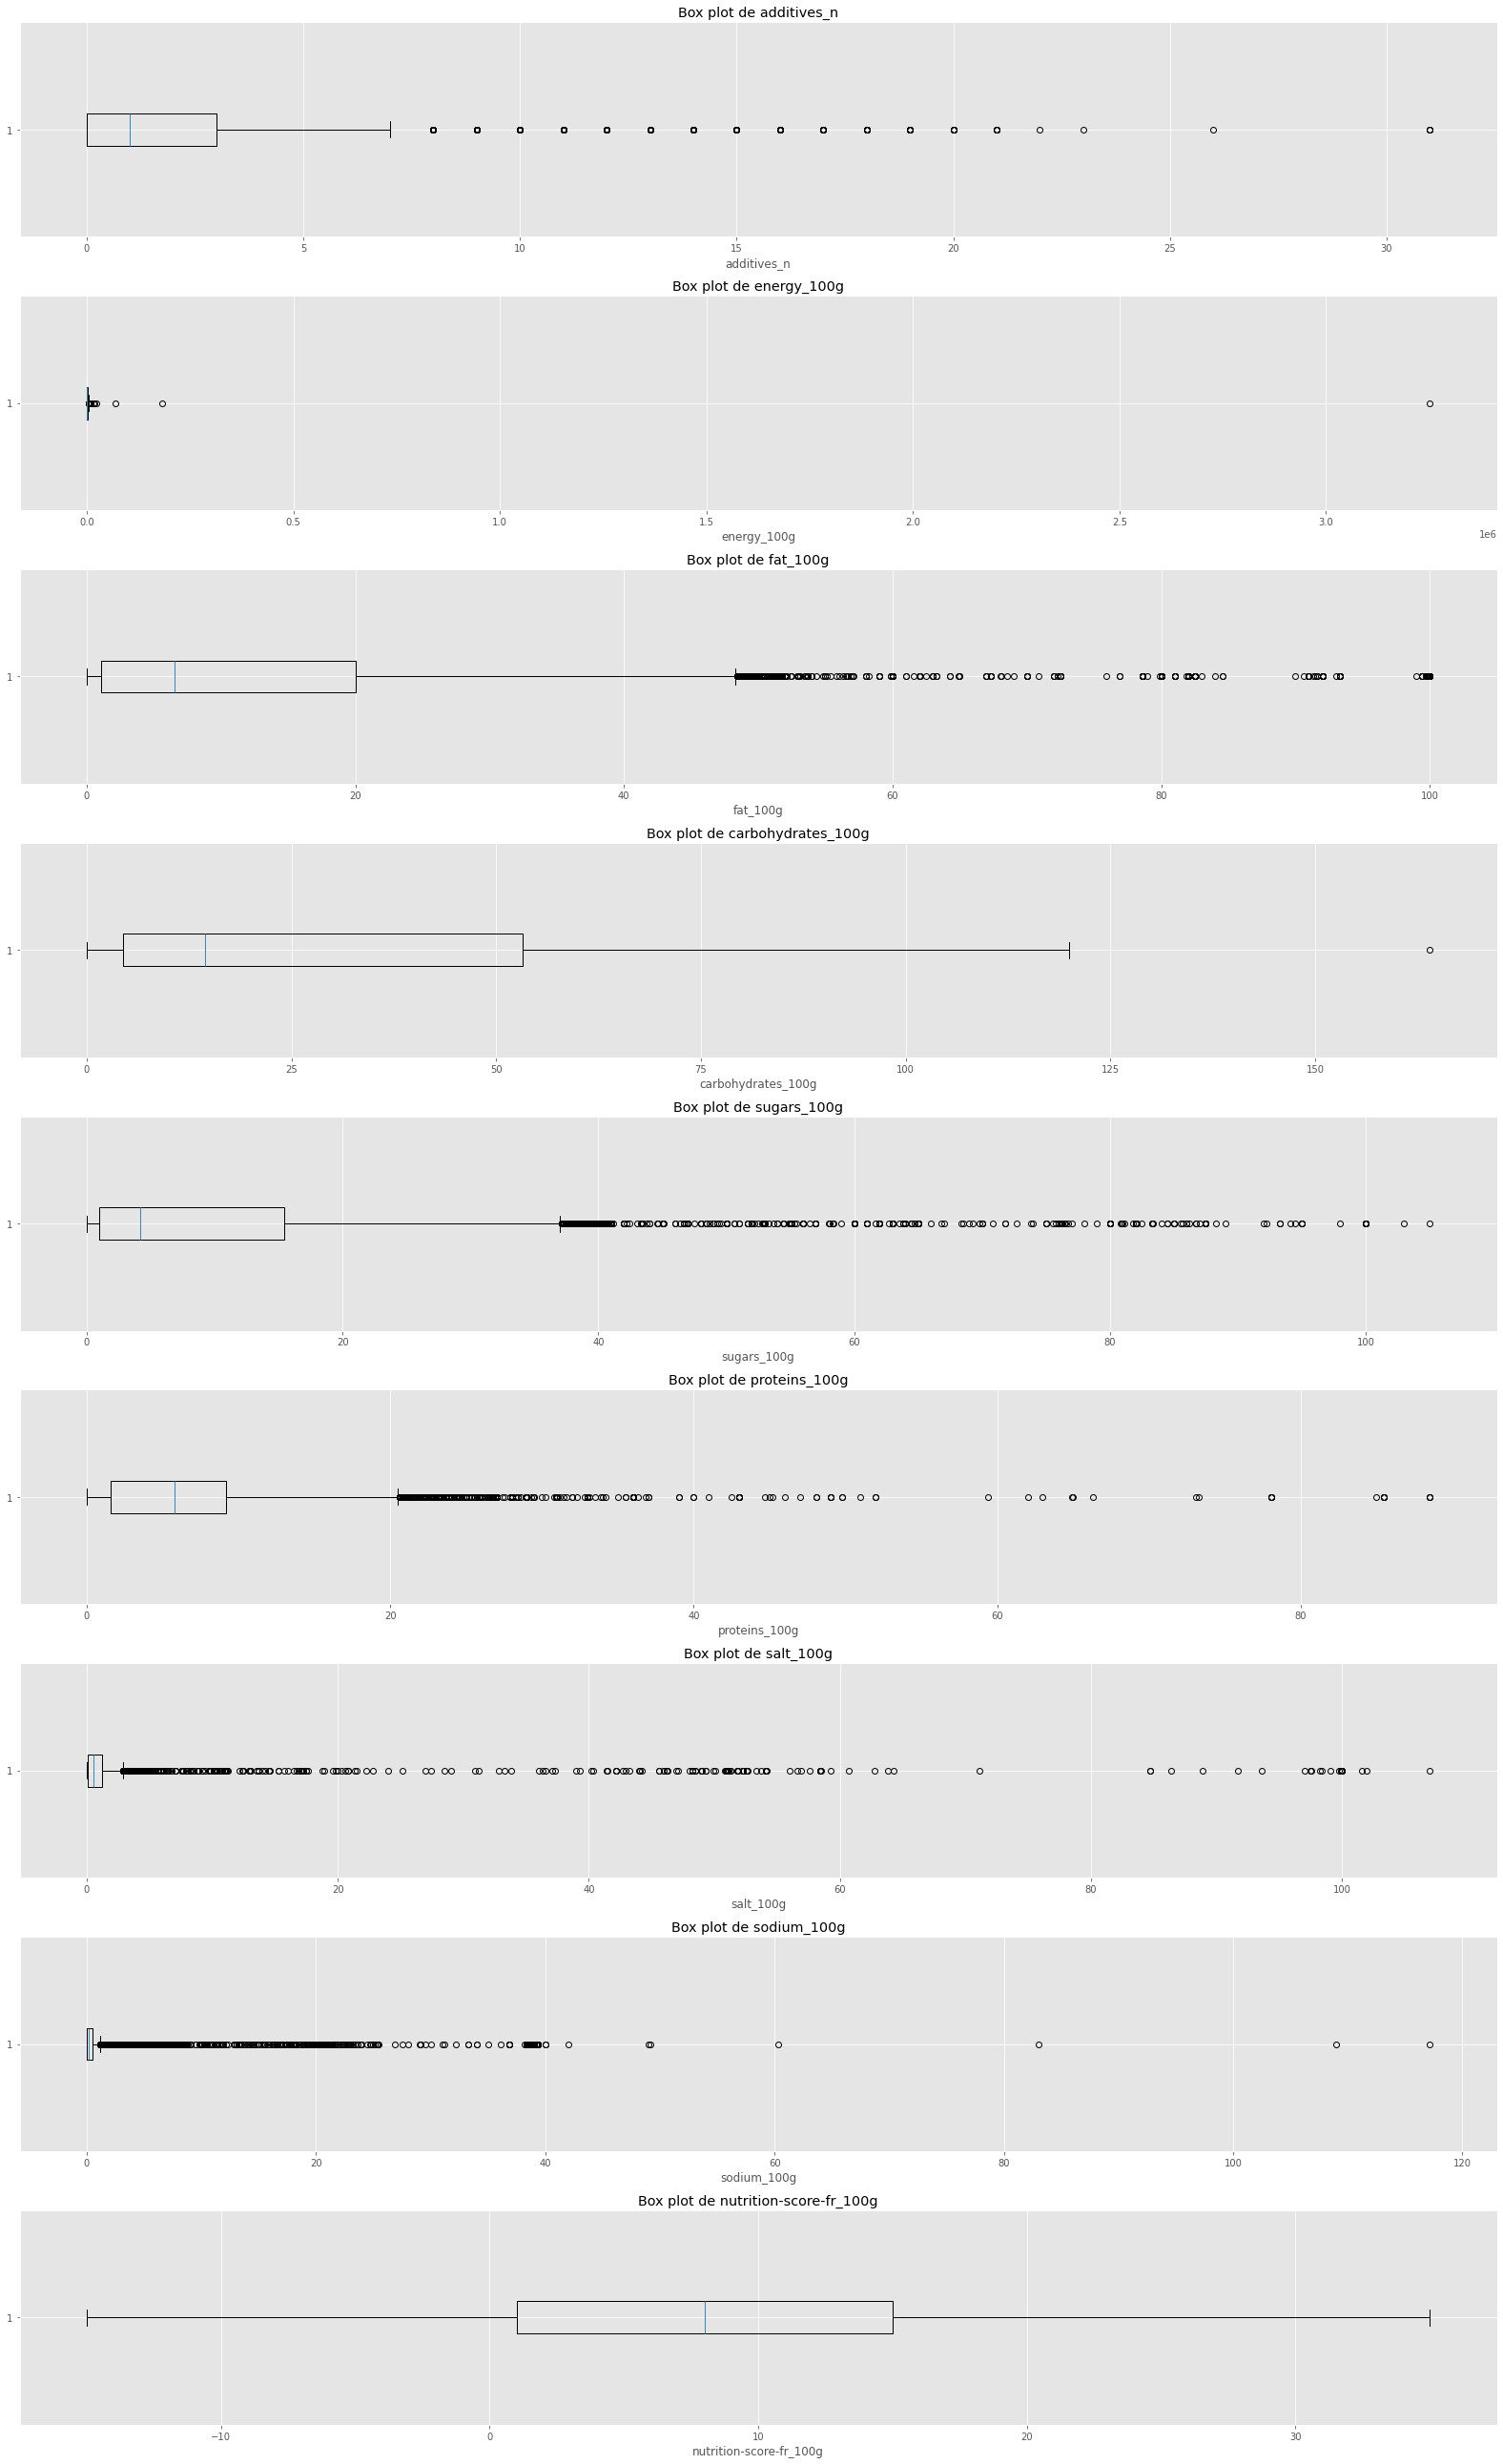

In [59]:
plt.figure(figsize=(22, len(numeric_cols) * 4))  # Ajuster la taille pour l'espace nécessaire
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    plt.boxplot(df_unique[col].dropna(), vert=False)
    plt.title(f"Box plot de {col}")
    plt.xlabel(col)

plt.tight_layout()
plt.show()

## Automate


In [ ]:
def group_by_nutriGrade(data):
# groub the df unique bt nutrition grade and calculate the mean of each column 
    nutritional_columns = ['additives_n','energy_100g',	'fat_100g',	'carbohydrates_100g','sugars_100g',	'proteins_100g','salt_100g','sodium_100g','nutrition-score-fr_100g','fiber_100g']
    grouped_by_grade = df_unique.groupby('nutrition_grade_fr')[nutritional_columns].mean()
    grouped_by_grade.reset_index()
    return grouped_by_grade

def display_num_outliers_per_ft(numeric_cols):
    outliers_dict = {}
    for col in numeric_cols:
        Q1 = df_unique[col].quantile(0.25)
        Q3 = df_unique[col].quantile(0.75)
        IQR = Q3 - Q1
    # Détection des valeurs aberrantes avec la méthode de l'IQR
    outliers = df_unique[(df_unique[col] < Q1 - 1.5 * IQR) | (df_unique[col] > Q3 + 1.5 * IQR)]
    outliers_dict[col] = outliers[col]
    
    print(f"Variable {col} : {len(outliers)} valeurs aberrantes détectées")

# Example function to identify outliers (you may use your own method)
def replace_outliers_with_grade_mean(df, grouped_byGrade, columns_to_check, grade_column='nutrition_grade_fr', threshold=1.5):
    """
    Replace outliers in specified columns with the mean value for their respective grade.

    Parameters:
    df (pandas.DataFrame): The input dataframe.
    grouped_byGrade (pandas.DataFrame): DataFrame containing mean values for each grade.
    columns_to_check (list): List of columns to check for outliers.
    grade_column (str): The column name representing the grade.
    threshold (float): The threshold for identifying outliers using the IQR method.

    Returns:
    pandas.DataFrame: The dataframe with outliers replaced.
    """
    def is_outlier(series, threshold=1.5):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        return (series < (Q1 - threshold * IQR)) | (series > (Q3 + threshold * IQR))

    for col in columns_to_check:
        # Identify outliers in the main DataFrame for the column
        outliers = is_outlier(df[col])

        # Replace each outlier with the mean for its respective grade, if grade is not NaN
        df.loc[outliers & df[grade_column].notna(), col] = df.loc[outliers & df[grade_column].notna()].apply(
            lambda row: grouped_byGrade.loc[row[grade_column], col], axis=1
        )
    return df

def automate_outlier_treatment(data):
    numeric_cols = data.select_dtypes(include=['number']).columns.tolist()
    display_num_outliers_per_ft(numeric_cols)
    print('Starting treatment ....')
    grouped_byGrade  = group_by_nutriGrade(data)
    df_unique = replace_outliers_with_grade_mean(data, grouped_byGrade, numeric_cols)
    display(df_unique.describe())
    return df_unique




## Recap 
- On a  corrigé les données pour les valeurs négatives pour les nutriments.
- On a utilisé la méthode de détection des outliers pour corriger les données aberrantes.
- On a traité les valeurs aberrantes en remplaçant les outliers par les moyennes de la catégorie de nutrition des produits.


In [60]:
# drop the column product Name
df_unique.drop(columns=['product_name'], inplace=True)

df_unique.head()

code          quantity  \
233026  3439495008821             180 g   
252415  3760065950029              35 g   
215032  3263850576515             400 g   
215033  3263850576614  400 g (8 x 50 g)   
215034  3263850576713  300 g (6 x 50 g)   

                                               packaging  \
233026                                       Bocal,Verre   
252415                         Film plastique,Point vert   
215032                             Carton,Étui,Plastique   
215033  Sachets plastique à jeter,Etui carton à recycler   
215034                                    Carton,Sachets   

                                                                                            categories_tags  \
233026        en:meats,en:spreads,en:prepared-meats,en:salted-spreads,en:savory-mousses,fr:mousses-de-foies   
252415                                                                             en:sugary-snacks,en:bars   
215032    en:sugary-snacks,en:biscuits-and-cakes,en:biscuits,en:chocolate-biscuits,fr:biscuits-aux-cereales   
215033  en:breakfasts,en:sugary-snacks,en:biscuits-and-cakes,en:biscuits,en:chocolate-biscuits,fr:biscui...   
215034    en:sugary-snacks,en:biscuits-and-cakes,en:biscuits,en:chocolate-biscuits,fr:biscuits-aux-cereales   

                                                                                           ingredients_text  \
233026  Gras de porc, foie de porc 25 %, _lait_, couenne, amidon modifié, conservateur ; sel nitrité, Co...   
252415  cernaux de noix bio 33, figue bio 32%, raisin bio 31%, crème de riz bio, ostie bio (fécule de po...   
215032  Farine de _blé_ 35,5 %, sucre, pépites de chocolat 13 % [sucre, pâte de cacao, beurre de cacao, ...   
215033  Farine de _blé_ 39,7 %, sucre, huile de tournesol, flocons d'_avoine_ 9,2 %, pépites de chocolat...   
215034  Farine de _blé_ 41,4 %, flocons d'_avoine_ 22,8 %, sucre, huile de tournesol, pépites de chocola...   

        additives_n nutrition_grade_fr       pnns_groups_2      main_category  \
233026          1.0                  e      Processed meat  en:salted-spreads   
252415          0.0                  d             unknown   en:sugary-snacks   
215032          4.0                  d  Biscuits and cakes        en:biscuits   
215033          4.0                  c  Biscuits and cakes      en:breakfasts   
215034          4.0                  c  Biscuits and cakes        en:biscuits   

        energy_100g  fat_100g  carbohydrates_100g  sugars_100g  proteins_100g  \
233026       1751.0      40.3                 3.2     1.800000           12.1   
252415       1800.0      23.6                44.4    16.822827            5.7   
215032       1911.0      17.5                63.0    30.000000            8.5   
215033       1914.0      17.0                65.0    26.000000            8.0   
215034       1852.0      15.0                65.0    19.000000            8.0   

        salt_100g  sodium_100g  nutrition-score-fr_100g  fiber_100g  
233026      1.778     0.700000                     22.0         NaN  
252415      0.060     0.023622                     11.0         NaN  
215032      0.650     0.255906                     11.0         NaN  
215033      0.730     0.287402                     10.0         NaN  
215034      0.750     0.295276                      9.0         NaN

# Imputation de valeurs manquantes

In [61]:
df_unique.dtypes

code                        object
quantity                    object
packaging                   object
categories_tags             object
ingredients_text            object
additives_n                float64
nutrition_grade_fr          object
pnns_groups_2               object
main_category               object
energy_100g                float64
fat_100g                   float64
carbohydrates_100g         float64
sugars_100g                float64
proteins_100g              float64
salt_100g                  float64
sodium_100g                float64
nutrition-score-fr_100g    float64
fiber_100g                 float64
dtype: object

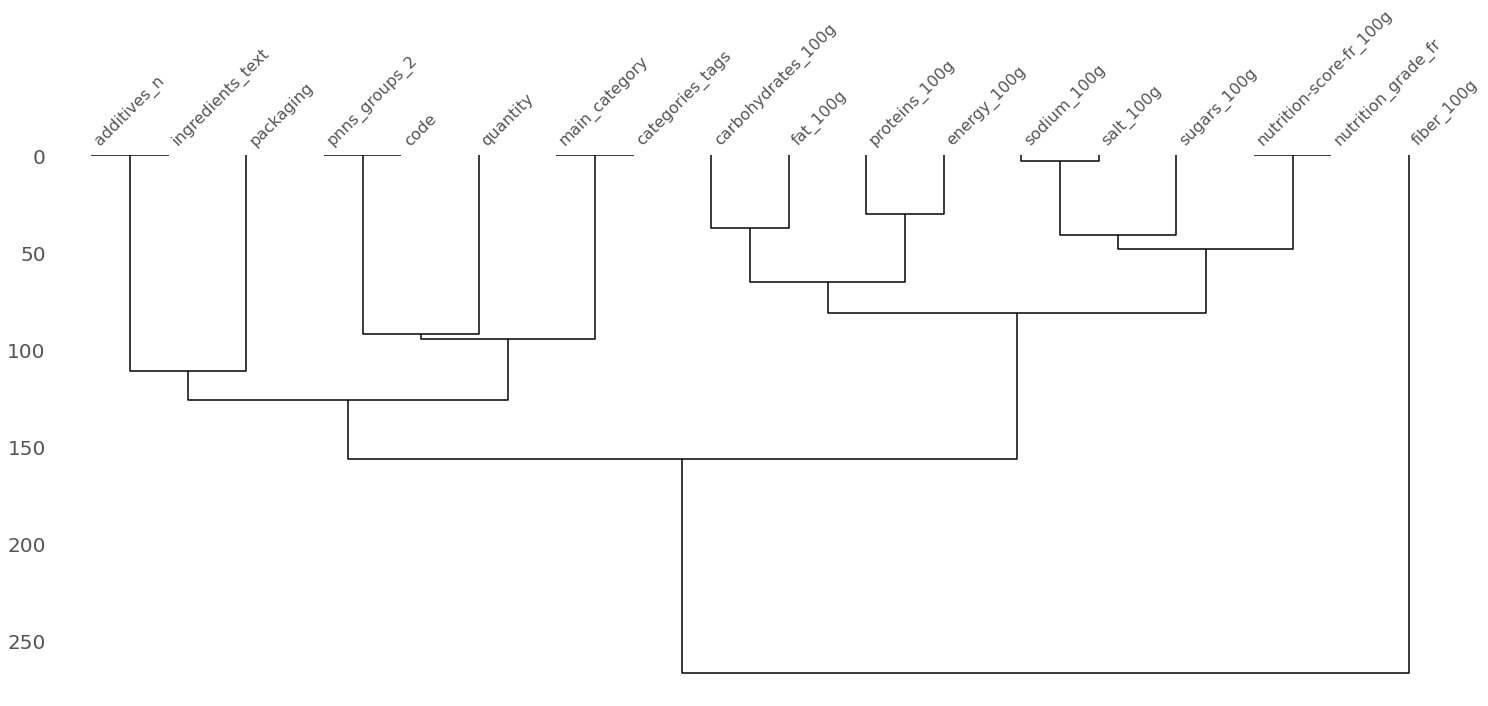

In [62]:
msn.dendrogram(df_unique)
plt.show()

In [63]:
for col in df_unique.columns:
    print(f'Valeurs manquantes pour {col} : {df_unique[col].isna().sum()}')

Valeurs manquantes pour code : 0
Valeurs manquantes pour quantity : 8493
Valeurs manquantes pour packaging : 16110
Valeurs manquantes pour categories_tags : 8552
Valeurs manquantes pour ingredients_text : 19565
Valeurs manquantes pour additives_n : 19565
Valeurs manquantes pour nutrition_grade_fr : 27938
Valeurs manquantes pour pnns_groups_2 : 0
Valeurs manquantes pour main_category : 8552
Valeurs manquantes pour energy_100g : 21962
Valeurs manquantes pour fat_100g : 25385
Valeurs manquantes pour carbohydrates_100g : 25835
Valeurs manquantes pour sugars_100g : 26136
Valeurs manquantes pour proteins_100g : 22626
Valeurs manquantes pour salt_100g : 25871
Valeurs manquantes pour sodium_100g : 25879
Valeurs manquantes pour nutrition-score-fr_100g : 27938
Valeurs manquantes pour fiber_100g : 89717


- Logic de verstack **NANImputer**:
  - toutes les colonnes seront vérifiées pour les valeurs manquantes
  - transformé en formats numériques
  - divisé en sous-ensembles avec et sans valeurs manquantes
  - Les modèles applicables seront sélectionnés et configurés pour chacune des colonnes avec des NaN.
  - Les NaN seront prédits et placés dans les index correspondants
  - les colonnes avec tous les NaN seront supprimées
  - les colonnes contenant des NaN et des valeurs connues sous la forme d'une seule constante seront supprimées
  - les colonnes avec plus de 50 % de NaN seront supprimées
  - les données seront transformées de manière inverse au format original

In [64]:
from verstack import NaNImputer
imputer = NaNImputer()

# imputer = NaNImputer(train_sample_size=30000, verbose=True)
df_imputed = imputer.impute(df_unique)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         89717
     .. columns:      18
     .. mb in memory: 13.01
     .. NaN cols num: 16

   - Drop hopeless NaN cols

   - droped column fiber_100g with NaNs and a constant non-NaN value
     . Missing values in quantity replaced by "Missing_data" string
     . Missing values in packaging replaced by "Missing_data" string
     . Missing values in categories_tags replaced by "Missing_data" string
     . Missing values in ingredients_text replaced by "Missing_data" string
     . Missing values in main_category replaced by "Missing_data" string

   - Processing whole data for imputation

   - Imputing single core 10 cols
     . Imputed (multiclass) - 19565    NaN in additives_n
     . Imputed (multiclass) - 27938    NaN in nutrition_grade_fr
     . Imputed (regression) - 21962    NaN in energy_100g
     . Imputed (regression) - 25385    NaN in fat_100g
     . Imputed (regression) - 25835    NaN in carbohydrates_

<Axes: >

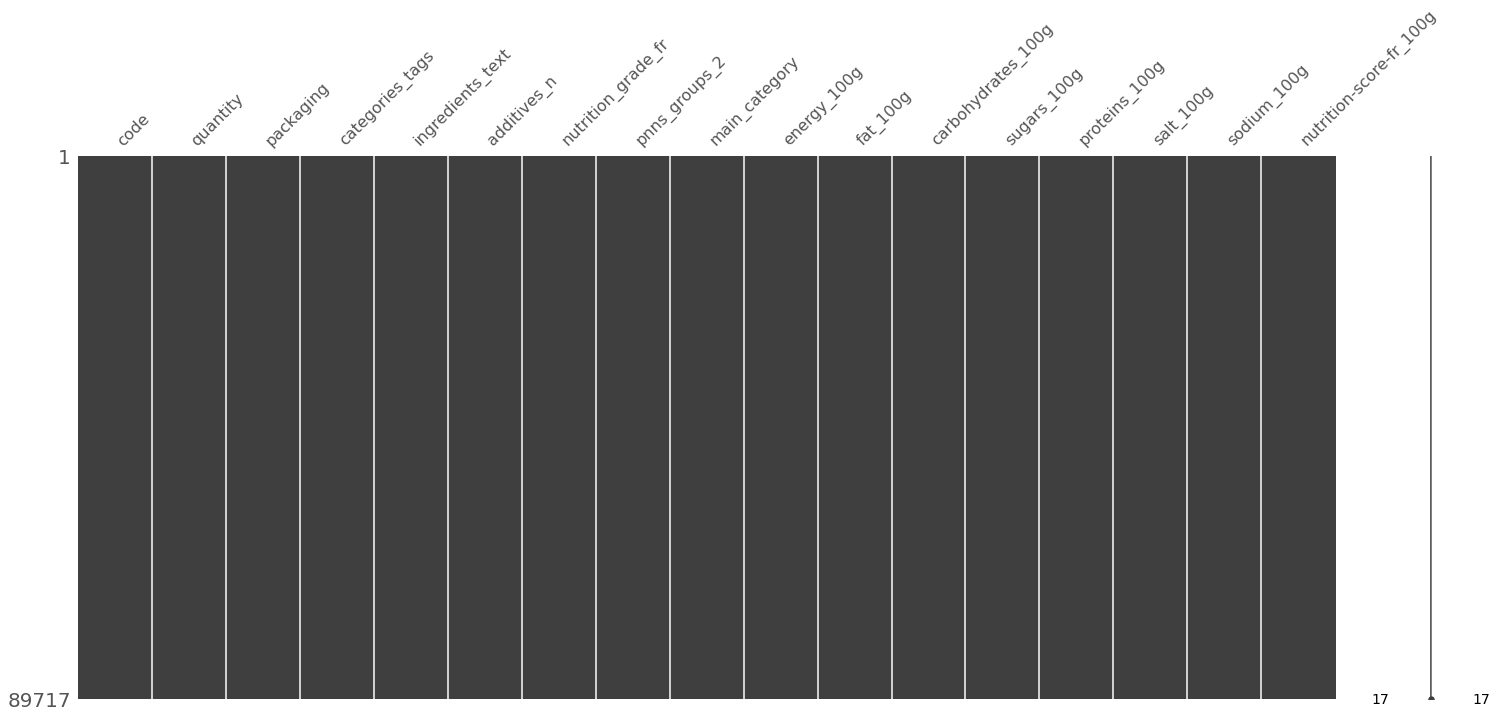

In [65]:
msn.matrix(df_imputed)

# Analyse Univariée et bivariée

In [66]:
from DataAnalysis import DataAnalysis  as DA

In [67]:
df_imputed.columns
df_final = df_imputed.copy()
df_final.reset_index(drop=True)

code          quantity  \
0      3439495008821             180 g   
1      3760065950029              35 g   
2      3263850576515             400 g   
3      3263850576614  400 g (8 x 50 g)   
4      3263850576713  300 g (6 x 50 g)   
...              ...               ...   
89712  7640159924791      Missing_data   
89713  5410126042474      Missing_data   
89714  2000000035330      Missing_data   
89715  2000000035336      Missing_data   
89716  6194043001668      Missing_data   

                                              packaging  \
0                                           Bocal,Verre   
1                             Film plastique,Point vert   
2                                 Carton,Étui,Plastique   
3      Sachets plastique à jeter,Etui carton à recycler   
4                                        Carton,Sachets   
...                                                 ...   
89712                                      Missing_data   
89713                                      Missing_data   
89714                                      Missing_data   
89715                                      Missing_data   
89716                                      Missing_data   

                                                                                           categories_tags  \
0            en:meats,en:spreads,en:prepared-meats,en:salted-spreads,en:savory-mousses,fr:mousses-de-foies   
1                                                                                 en:sugary-snacks,en:bars   
2        en:sugary-snacks,en:biscuits-and-cakes,en:biscuits,en:chocolate-biscuits,fr:biscuits-aux-cereales   
3      en:breakfasts,en:sugary-snacks,en:biscuits-and-cakes,en:biscuits,en:chocolate-biscuits,fr:biscui...   
4        en:sugary-snacks,en:biscuits-and-cakes,en:biscuits,en:chocolate-biscuits,fr:biscuits-aux-cereales   
...                                                                                                    ...   
89712                                                                                         Missing_data   
89713                                                                                         Missing_data   
89714                                                                                         Missing_data   
89715                                                                                         Missing_data   
89716                                                                                         Missing_data   

                                                                                          ingredients_text  \
0      Gras de porc, foie de porc 25 %, _lait_, couenne, amidon modifié, conservateur ; sel nitrité, Co...   
1      cernaux de noix bio 33, figue bio 32%, raisin bio 31%, crème de riz bio, ostie bio (fécule de po...   
2      Farine de _blé_ 35,5 %, sucre, pépites de chocolat 13 % [sucre, pâte de cacao, beurre de cacao, ...   
3      Farine de _blé_ 39,7 %, sucre, huile de tournesol, flocons d'_avoine_ 9,2 %, pépites de chocolat...   
4      Farine de _blé_ 41,4 %, flocons d'_avoine_ 22,8 %, sucre, huile de tournesol, pépites de chocola...   
...                                                                                                    ...   
89712                                                                                         Missing_data   
89713                                                                                         Missing_data   
89714                                                                                         Missing_data   
89715                                                                                         Missing_data   
89716                                                                                         Missing_data   

       additives_n nutrition_grade_fr       pnns_groups_2      main_category  \
0              1.0                  e      Processed meat  en:salted-spreads   


## Univariée

### distribution des features numérique

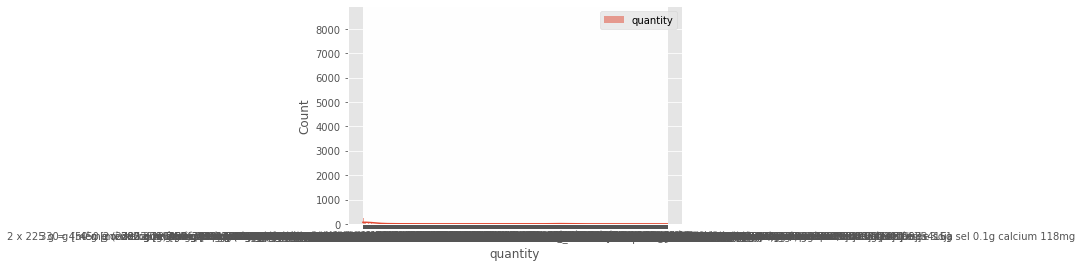

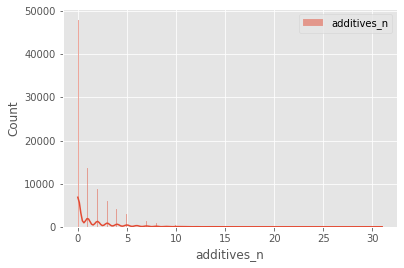

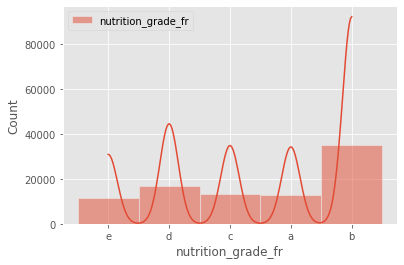

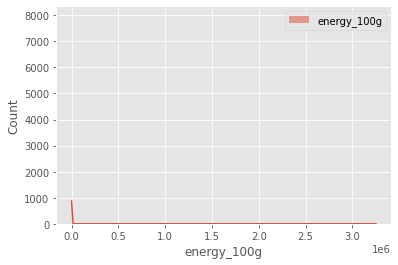

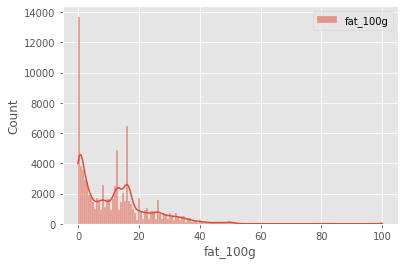

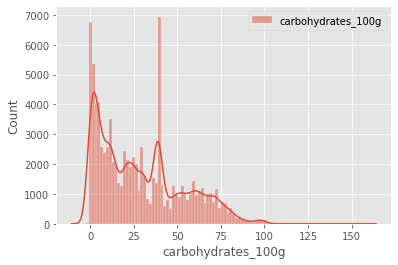

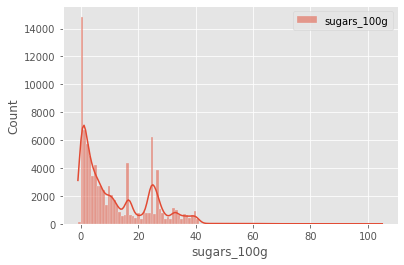

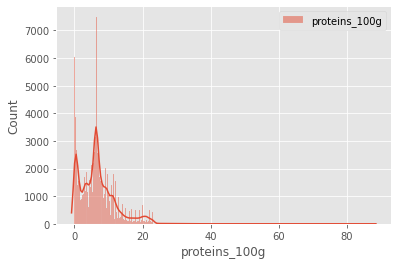

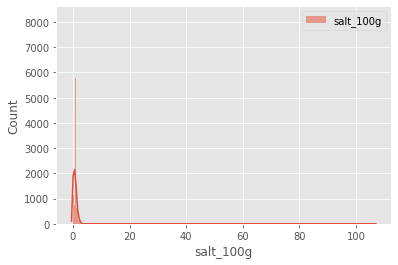

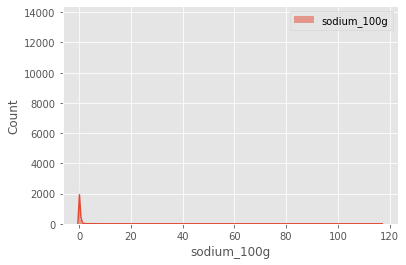

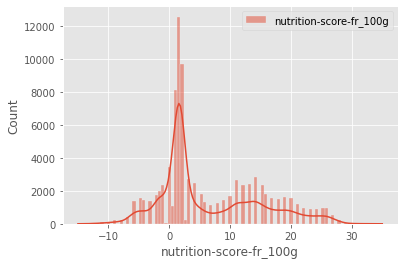

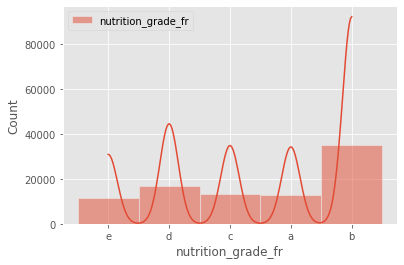

In [ ]:
# plot ditribution of each feature 
intersting_cols = ['additives_n','nutrition_grade_fr','energy_100g'	,'fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g'	,'sodium_100g'	,'nutrition-score-fr_100g', 'nutrition_grade_fr']
for feature in intersting_cols:
    sns.histplot(df_final[feature], kde=True, label=feature)
    plt.legend()
    plt.show()

### Categorical features

In [69]:
import plotly.express as px

def plot_treemap(df, column):
    value_counts = df[column].value_counts().reset_index()
    value_counts.columns = [column, 'count']
    
    fig = px.treemap(value_counts, path=[column], values='count')
    fig.update_layout(title=f'Treemap of {column}')
    fig.show()

# Usage
plot_treemap(df_final, 'main_category')
plot_treemap(df_final, 'packaging')

In [70]:
import plotly.graph_objects as go

def plot_scrollable_barplot(df, column):
    value_counts = df[column].value_counts()
    
    fig = go.Figure(go.Bar(
        x=value_counts.values,
        y=value_counts.index,
        orientation='h'
    ))
    
    fig.update_layout(
        title=f'Distribution of {column}',
        yaxis={'categoryorder':'total ascending'},
        height=600,
        margin=dict(l=100, r=20, t=70, b=70),
    )
    
    fig.show()

# Usage
plot_scrollable_barplot(df_final, 'pnns_groups_2')

target

In [71]:
plot_scrollable_barplot(target_df, 'pnns_groups_1')

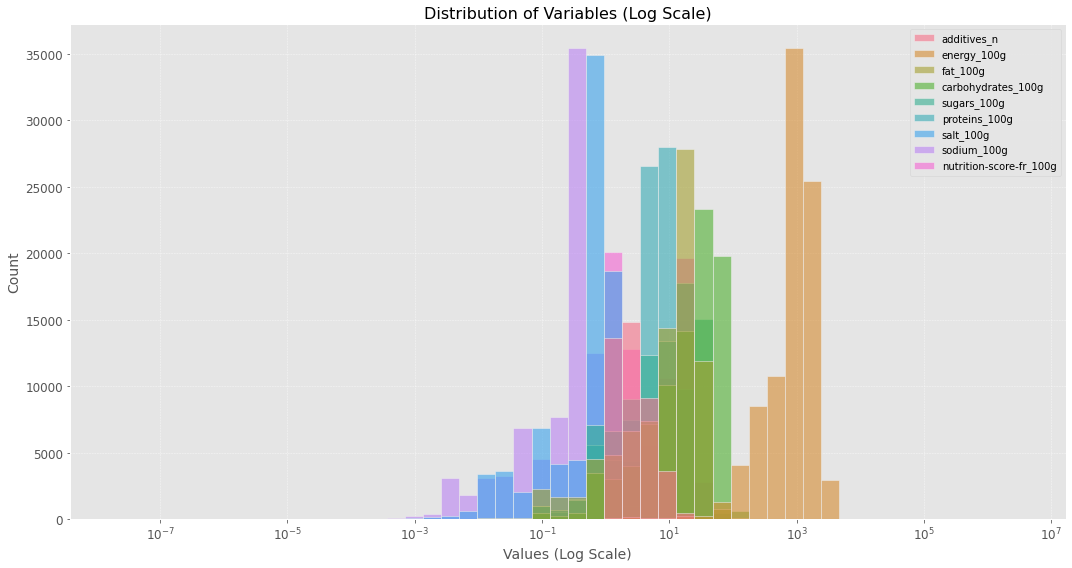

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define plot dimensions
plt.figure(figsize=(15, 8))

# Create a histogram with better transparency and log scale
sns.histplot(df_imputed, log_scale=(True, False), alpha=0.6, bins=50, kde=False)

# Customize ticks for better readability on the logarithmic scale
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid lines to assist in interpreting log scale
plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)

# Set title and labels
plt.title("Distribution of Variables (Log Scale)", fontsize=16)
plt.xlabel("Values (Log Scale)", fontsize=14)
plt.ylabel("Count", fontsize=14)

# Place the legend outside the plot for better visibility
# plt.legend(title="Features", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.tight_layout()

plt.show()


<Axes: xlabel='proportion', ylabel='Density'>

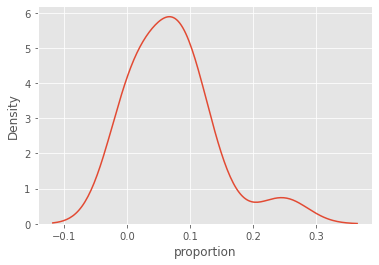

In [73]:
sns.kdeplot(target_df['pnns_groups_1'].value_counts(normalize=True))

## Bivariate analysis

### numéric features relationship 

In [74]:
df_final.columns


Index(['code', 'quantity', 'packaging', 'categories_tags', 'ingredients_text',
       'additives_n', 'nutrition_grade_fr', 'pnns_groups_2', 'main_category',
       'energy_100g', 'fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g'],
      dtype='object')

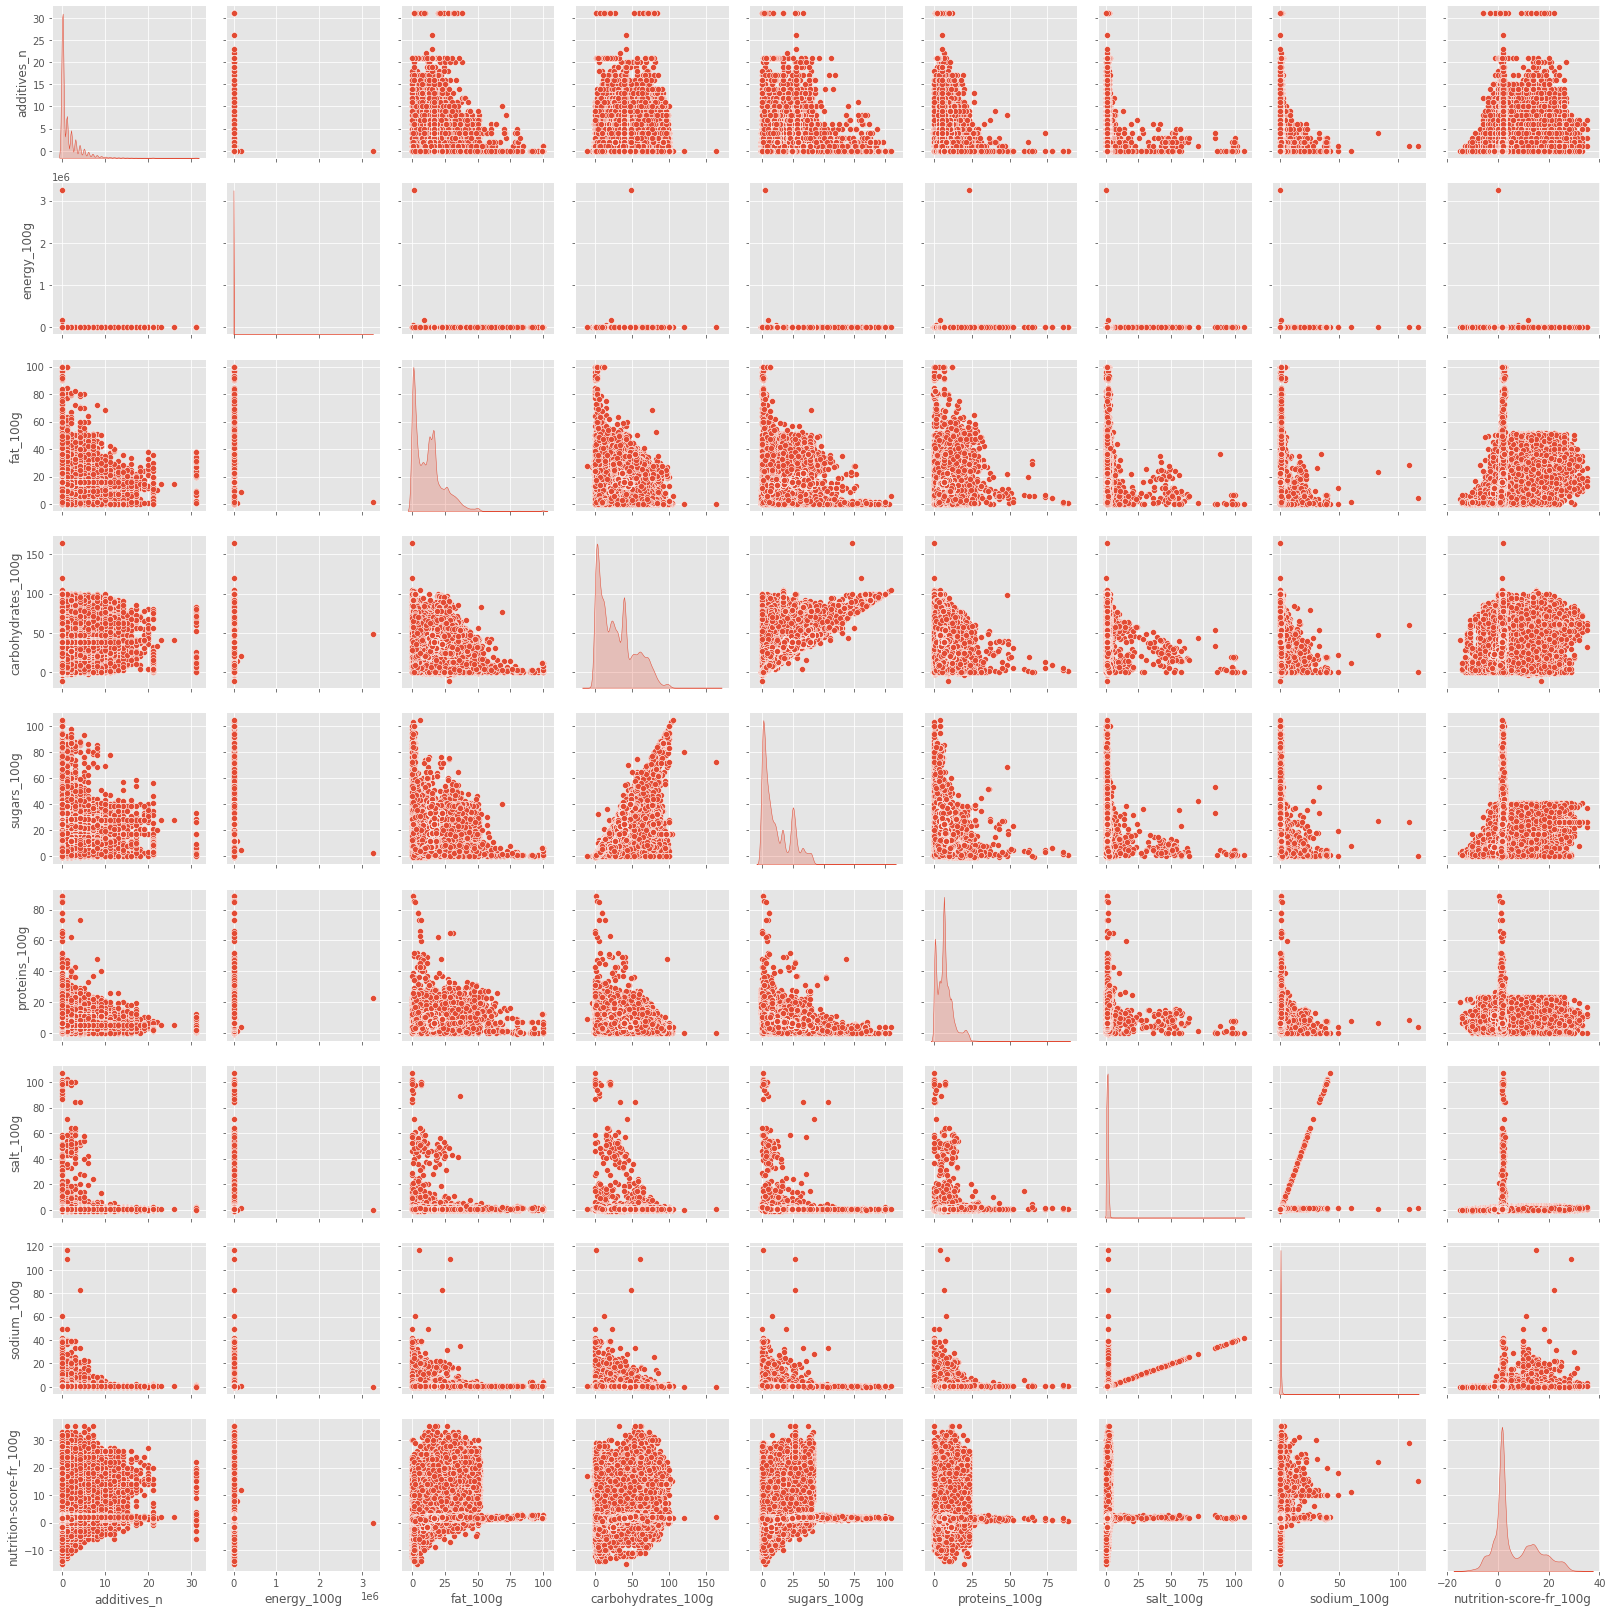

In [75]:
# Create a pairplot
numeric_cols = ['quantity', 
       'additives_n', 'nutrition_grade_fr', 'pnns_groups_2', 'main_category',
       'energy_100g', 'fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g']
sns.pairplot(df_final[numeric_cols], diag_kind='kde')
plt.tight_layout()
plt.show()

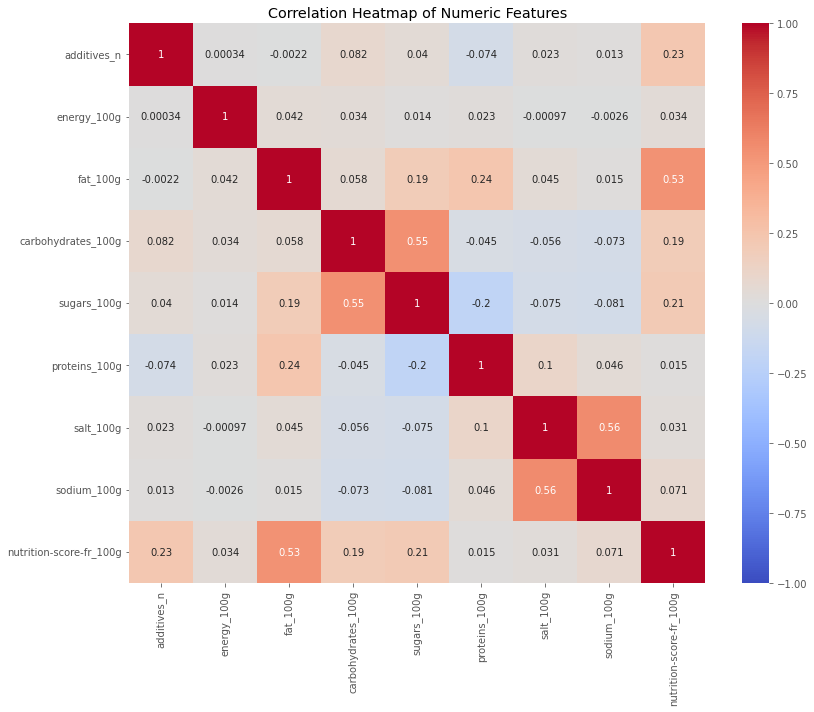

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only the numeric columns
numeric_columns = df_final.select_dtypes(include=['float64', 'int64']).columns

# Create a correlation matrix
correlation_matrix = df_final[numeric_columns].corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

### Categorical only

In [78]:
cat_cols = ['quantity', 'packaging', 'categories_tags', 'ingredients_text','pnns_groups_2', 'main_category']
def cramers_v(x, y):
    """
    Calculate Cramér's V statistic for categorical-categorical association.
    
    Parameters:
        x (pd.Series): A categorical feature.
        y (pd.Series): Another categorical feature.
    
    Returns:
        float: Cramér's V statistic.
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


#### main_category & pnns_groups_2

In [79]:


# Example usage
for i in range(len(cat_cols)):
    for j in range(i + 1, len(cat_cols)):
        feature1 = df_final[cat_cols[i]]
        feature2 = df_final[cat_cols[j]]
        correlation = cramers_v(feature1, feature2)
        print(f"Cramér's V correlation between {cat_cols[i]} and {cat_cols[j]}: {correlation}")

Cramér's V correlation between quantity and packaging: 0.32697241308496877
Cramér's V correlation between quantity and categories_tags: 0.22678390639151053
Cramér's V correlation between quantity and ingredients_text: 0.25566006454750834
Cramér's V correlation between quantity and pnns_groups_2: 0.3132684663968135
Cramér's V correlation between quantity and main_category: 0.16349636696347675
Cramér's V correlation between packaging and categories_tags: 0.33335983259465096
Cramér's V correlation between packaging and ingredients_text: 0.39761258281127465
Cramér's V correlation between packaging and pnns_groups_2: 0.3475029023565271
Cramér's V correlation between packaging and main_category: 0.23376081841603913


: 

In [ ]:
contingency_table = pd.crosstab(df_final['main_category'], df_final['pnns_groups_2'])
contingency_table


pnns_groups_2               Appetizers  Artificially sweetened beverages  \
main_category                                                              
Missing_data                         0                                 0   
ar:chocolat                          0                                 0   
ar:eau-de-javel-concentree           0                                 0   
ar:hummos                            0                                 0   
ar:juice                             0                                 0   
...                                ...                               ...   
xx:вафли                             0                                 0   
xx:スナック菓子                            0                                 0   
xx:煎茶                                0                                 0   
zh:sauce-de-soja                     0                                 0   
zh:复原乳                               0                                 0   

pnns_groups_2               Biscuits and cakes  Bread  Breakfast cereals  \
main_category                                                              
Missing_data                                 0      0                  0   
ar:chocolat                                  0      0                  0   
ar:eau-de-javel-concentree                   0      0                  0   
ar:hummos                                    0      0                  0   
ar:juice                                     0      0                  0   
...                                        ...    ...                ...   
xx:вафли                                     0      0                  0   
xx:スナック菓子                                    0      0                  0   
xx:煎茶                                        0      0                  0   
zh:sauce-de-soja                             0      0                  0   
zh:复原乳                                       0      0                  0   

pnns_groups_2               Cereals  Cheese  Chocolate products  \
main_category                                                     
Missing_data                      0       0                   0   
ar:chocolat                       0       0                   0   
ar:eau-de-javel-concentree        0       0                   0   
ar:hummos                         0       0                   0   
ar:juice                          0       0                   0   
...                             ...     ...                 ...   
xx:вафли                          0       0                   0   
xx:スナック菓子                         0       0                   0   
xx:煎茶                             0       0                   0   
zh:sauce-de-soja                  0       0                   0   
zh:复原乳                            0       0                   0   

pnns_groups_2               Dairy desserts  Dressings and sauces  \
main_category                                                      
Missing_data                             0                     0   
ar:chocolat                              0                     0   
ar:eau-de-javel-concentree               0                     0   
ar:hummos                                0                     0   
ar:juice                                 0                     0   
...                                    ...                   ...   
xx:вафли                                 0                     0   
xx:スナック菓子                                0                     0   
xx:煎茶                                    0                     0   
zh:sauce-de-soja                         0                     0   
zh:复原乳                                   0                     0   

pnns_groups_2               Dried fruits  Eggs  Fats  Fish and seafood  \
main_category                                                            
Missing_data                           0     0     0                 0   
ar:chocolat                            0   

In [ ]:
chi2_contingency

### Categorical and Numeric

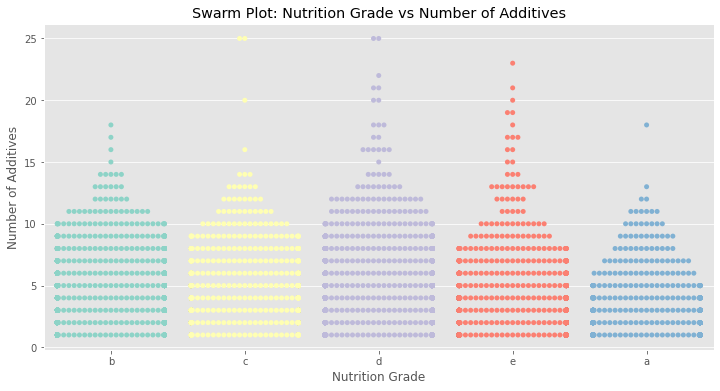

In [74]:
plt.figure(figsize=(12, 6))
sns.swarmplot(data=df_imputed.sample(10000), x='nutrition_grade_fr', y='additives_n', palette='Set3')
plt.title("Swarm Plot: Nutrition Grade vs Number of Additives")
plt.xlabel("Nutrition Grade")
plt.ylabel("Number of Additives")
plt.show()


### Notre cible  Analyse en fonction de la variable cible

In [88]:
for i in cat_cols:
    contingency_table = pd.crosstab(index=target_df['pnns_groups_1'], columns=df_final[i])
    print(f'The p value between target and {i} is {chi2_contingency(contingency_table).pvalue}')

The p value between target and quantity is 0.9999999924047658
The p value between target and packaging is 0.6923363224596286
The p value between target and categories_tags is 0.9977028206300345
The p value between target and ingredients_text is 2.0910836058111121e-13
The p value between target and pnns_groups_2 is 0.0451595319586944
The p value between target and main_category is 0.9999540862470404


In [102]:
df_with_target = df_final.copy()
df_with_target['target'] = target_df['pnns_groups_1']


In [ ]:
grouped_byGroup = df_with_target.groupBy('pnns_groups_1')['grade']

#### Distribution of Additives by Ingredients


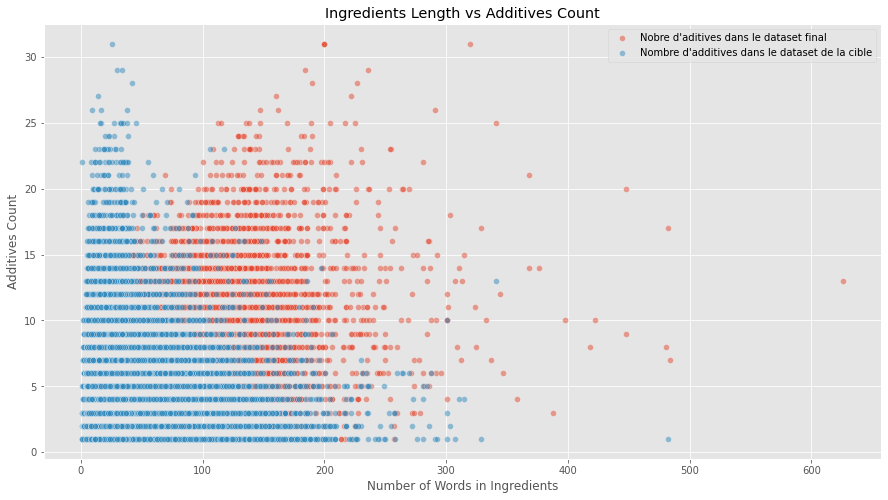

In [76]:
# 6. Distribution of Additives by Ingredients
plt.figure(figsize=(15,8))
df['ingredients_length'] = df['ingredients_text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
sns.scatterplot(x=df['ingredients_length'], y=df['additives_n'], alpha=0.5, label="Nobre d'aditives dans le dataset final")
sns.scatterplot(x=df['ingredients_length'], y=target_df['additives_count'], alpha=0.5, label="Nombre d'additives dans le dataset de la cible")
plt.title("Ingredients Length vs Additives Count")
plt.xlabel("Number of Words in Ingredients")
plt.ylabel("Additives Count")
plt.show()

# Partie 5: Analyse multi-variée

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy import stats
import numpy as np

class AdvancedDataAnalysis(DA):  # Hérite de votre classe DataAnalysis existante
    
    def correlation_matrix(self):
        plt.figure(figsize=(12, 8))
        sns.heatmap(self.df.corr(), annot=True, cmap='coolwarm')
        plt.title("Matrice de Corrélation")
        plt.show()
    
    def pca_analysis(self, n_components=2):
        features = self.df.select_dtypes(include=[np.number])  # Variables numériques
        features_scaled = StandardScaler().fit_transform(features)
        
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(features_scaled)
        
        plt.figure(figsize=(10, 7))
        plt.scatter(pca_result[:, 0], pca_result[:, 1], c=self.df['nutrition_grade_fr'].astype('category').cat.codes)
        plt.xlabel('Composante Principale 1')
        plt.ylabel('Composante Principale 2')
        plt.colorbar()
        plt.title("ACP - Projection des Données")
        plt.show()
    
    def anova_test(self, target, feature):
        model = sm.OLS(self.df[target], sm.add_constant(self.df[feature])).fit()
        print(model.summary())
    
    def subgroup_analysis(self, subgroup_feature):
        subgroups = self.df[subgroup_feature].unique()
        for group in subgroups:
            subset = self.df[self.df[subgroup_feature] == group]
            print(f"\nSous-groupe '{group}':")
            display(subset.describe())
    
    def plot_3d(self, x, y, z):
        fig = plt.figure(figsize=(20,20))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.df[x], self.df[y], self.df[z], c=self.df['nutrition_grade_fr'].astype('category').cat.codes)
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_zlabel(z)
        plt.show()


In [90]:
# Convert nutrition_grade_fr to a categorical code if it's not numeric
if df_imputed['nutrition_grade_fr'].dtype == 'object':
    df_imputed['nutrition_grade_fr'] = df_imputed['nutrition_grade_fr'].astype('category').cat.codes

# Vérifiez que nutrition-score-fr_100g est bien de type numérique
df_imputed['nutrition-score-fr_100g'] = pd.to_numeric(df_imputed['nutrition-score-fr_100g'], errors='coerce')

# Relancez l'analyse en créant une nouvelle instance de AdvancedDataAnalysis
advanced_analysis = AdvancedDataAnalysis(df_imputed[['nutrition_grade_fr', 'nutrition-score-fr_100g']])
advanced_analysis.anova_test('nutrition-score-fr_100g', 'nutrition_grade_fr')


                               OLS Regression Results                              
Dep. Variable:     nutrition-score-fr_100g   R-squared:                       0.905
Model:                                 OLS   Adj. R-squared:                  0.905
Method:                      Least Squares   F-statistic:                 8.505e+05
Date:                     Thu, 09 Jan 2025   Prob (F-statistic):               0.00
Time:                             15:29:34   Log-Likelihood:            -2.1129e+05
No. Observations:                    89717   AIC:                         4.226e+05
Df Residuals:                        89715   BIC:                         4.226e+05
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [82]:
advanced_analysis = AdvancedDataAnalysis(df_imputed[['code', 'countries', 'ingredients_text', 'additives_n', 'additives',
       'additives_tags', 'nutrition_grade_fr', 'fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'nutrition-score-fr_100g']])
advanced_analysis.subgroup_analysis('nutrition_grade_fr')



Sous-groupe '2':


additives_n  nutrition_grade_fr      fat_100g  carbohydrates_100g  \
count  25255.000000             25255.0  25255.000000        25255.000000   
mean       3.110354                 2.0      6.826377           32.049489   
std        2.519312                 0.0      7.461990           26.696066   
min        1.000000                 2.0      0.000000            0.000000   
25%        1.000000                 2.0      1.000000            9.300000   
50%        2.000000                 2.0      4.840000           23.330000   
75%        4.000000                 2.0     10.000000           54.200000   
max       31.000000                 2.0     47.000000          100.000000   

        sugars_100g    fiber_100g  proteins_100g     salt_100g  \
count  25255.000000  25255.000000   25255.000000  25255.000000   
mean      10.566109      1.952949       5.717232      1.019131   
std       12.814036      2.019891       5.212133      0.771872   
min        0.000000     -0.280169       0.000000      0.000000   
25%        1.500000      0.200000       1.250000      0.238760   
50%        4.800000      1.400000       4.630000      1.016000   
75%       16.670000      2.900000       8.570000      1.600000   
max       74.190000      8.200000      21.250000      3.629660   

       nutrition-score-fr_100g  
count             25255.000000  
mean                  6.390339  
std                   2.521124  
min                   2.000000  
25%                   4.000000  
50%                   6.000000  
75%                   9.000000  
max                  10.000000


Sous-groupe '0':


additives_n  nutrition_grade_fr      fat_100g  carbohydrates_100g  \
count  12867.000000             12867.0  12867.000000        12867.000000   
mean       2.487604                 0.0      2.637947           27.117526   
std        2.033926                 0.0      3.423377           25.838881   
min        1.000000                 0.0      0.000000            0.000000   
25%        1.000000                 0.0      0.200000            7.545000   
50%        2.000000                 0.0      1.790000           14.670000   
75%        3.000000                 0.0      3.510000           46.150000   
max       18.000000                 0.0     40.140000           96.670000   

        sugars_100g    fiber_100g  proteins_100g     salt_100g  \
count  12867.000000  12867.000000   12867.000000  12867.000000   
mean       4.253296      2.702350       7.441868      0.459861   
std        4.470754      1.873452       4.833168      0.435143   
min        0.000000     -0.074539       0.000000      0.000000   
25%        1.100000      1.300000       3.500000      0.062230   
50%        3.280000      2.800000       7.560000      0.340000   
75%        5.650000      3.600000      10.710000      0.820000   
max       37.900000      8.200000      21.240000      2.500000   

       nutrition-score-fr_100g  
count             12867.000000  
mean                 -2.979172  
std                   1.893652  
min                 -13.000000  
25%                  -4.000000  
50%                  -3.000000  
75%                  -1.000000  
max                  17.000000


Sous-groupe '3':


additives_n  nutrition_grade_fr      fat_100g  carbohydrates_100g  \
count  39123.000000             39123.0  39123.000000        39123.000000   
mean       3.547555                 3.0     13.085626           45.199591   
std        2.781222                 0.0     11.059547           29.035033   
min        1.000000                 3.0     -0.313069            0.000000   
25%        2.000000                 3.0      3.030000           21.000000   
50%        3.000000                 3.0     12.000000           46.970000   
75%        5.000000                 3.0     19.695000           70.000000   
max       31.000000                 3.0     47.000000          100.000000   

        sugars_100g    fiber_100g  proteins_100g     salt_100g  \
count  39123.000000  39123.000000   39123.000000  39123.000000   
mean      21.260595      1.548236       5.966761      1.061774   
std       19.468634      1.911642       4.954856      0.898270   
min        0.000000     -0.670756       0.000000      0.000000   
25%        3.570000      0.000000       2.490000      0.200000   
50%       20.000000      0.800000       5.260000      0.919480   
75%       32.000000      2.500000       8.100000      1.663373   
max       74.300000      8.200000      21.280000      3.629660   

       nutrition-score-fr_100g  
count             39123.000000  
mean                 14.152545  
std                   2.287342  
min                   6.000000  
25%                  12.000000  
50%                  14.000000  
75%                  16.000000  
max                  18.000000


Sous-groupe '1':


additives_n  nutrition_grade_fr      fat_100g  carbohydrates_100g  \
count  38119.000000             38119.0  38119.000000        38119.000000   
mean       3.183085                 1.0      3.209533           24.465608   
std        2.423829                 0.0      8.410576           28.666147   
min        1.000000                 1.0     -1.176224            0.000000   
25%        1.000000                 1.0      0.000000            4.580000   
50%        2.000000                 1.0      0.000000           12.080000   
75%        4.000000                 1.0      2.800000           36.155000   
max       23.000000                 1.0    100.000000          100.000000   

        sugars_100g    fiber_100g  proteins_100g     salt_100g  \
count  38119.000000  38119.000000   38119.000000  38119.000000   
mean      14.169799      1.792451       3.159173      2.285643   
std       21.920007      2.480111       5.736772      9.381015   
min       -4.078233     -2.518495      -1.018440      0.000000   
25%        1.320923      0.436377       0.000000      0.017780   
50%        5.500000      1.140026       0.000000      0.193040   
75%       13.240000      2.329799       4.800000      1.143000   
max      100.000000    100.000000     100.000000    100.000000   

       nutrition-score-fr_100g  
count             38119.000000  
mean                  1.632997  
std                   1.311926  
min                  -6.000000  
25%                   0.717329  
50%                   1.152230  
75%                   2.506840  
max                   6.989928


Sous-groupe '4':


additives_n  nutrition_grade_fr      fat_100g  carbohydrates_100g  \
count  29307.000000             29307.0  29307.000000        29307.000000   
mean       2.829904                 4.0     23.781983           44.339216   
std        2.462612                 0.0     10.314379           26.875700   
min        1.000000                 4.0     -0.162930            0.000000   
25%        1.000000                 4.0     18.300000           11.000000   
50%        2.000000                 4.0     25.000000           54.200000   
75%        3.000000                 4.0     30.950000           64.290000   
max       28.000000                 4.0     47.000000          100.000000   

        sugars_100g    fiber_100g  proteins_100g     salt_100g  \
count  29307.000000  29307.000000   29307.000000  29307.000000   
mean      29.329210      1.419487       6.131164      1.046790   
std       21.047466      1.791754       4.247139      0.883247   
min        0.000000     -0.520593       0.000000      0.000000   
25%        5.615000      0.000000       3.330000      0.271780   
50%       33.330000      0.506527       5.710000      0.845820   
75%       46.430000      2.500000       8.095190      1.559560   
max       74.200000      8.200000      21.210000      3.630000   

       nutrition-score-fr_100g  
count             29307.000000  
mean                 22.133347  
std                   3.173818  
min                  10.000000  
25%                  20.000000  
50%                  22.000000  
75%                  24.000000  
max                  40.000000

## PCA analysis

In [95]:
print(numeric_cols)

['quantity', 'additives_n', 'nutrition_grade_fr', 'pnns_groups_2', 'main_category', 'energy_100g', 'fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g']


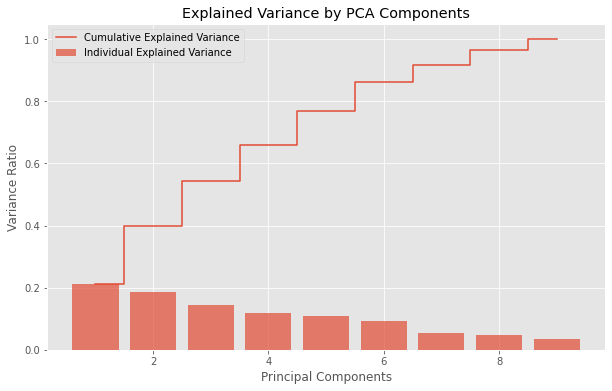

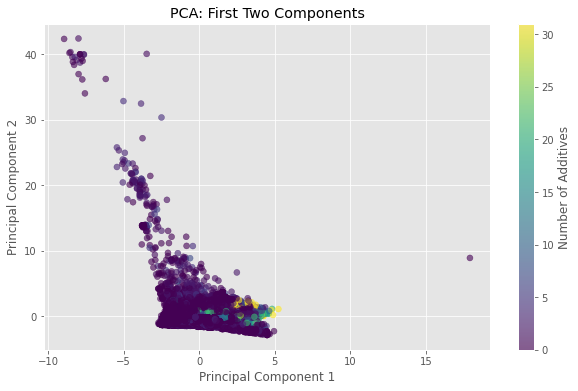

Feature Contributions to Principal Components:
                              PC1       PC2       PC3       PC4       PC5  \
additives_n              0.193522  0.064896  0.151532 -0.778853  0.187171   
energy_100g              0.063399  0.029951 -0.085235  0.205012  0.970498   
fat_100g                 0.417033  0.313694 -0.456472  0.052539 -0.102883   
carbohydrates_100g       0.482788 -0.144519  0.310443  0.300555 -0.024118   
sugars_100g              0.525283 -0.160015  0.309780  0.278756 -0.079383   
proteins_100g           -0.050654  0.293846 -0.506552  0.285463 -0.074097   
salt_100g               -0.096726  0.591739  0.354037  0.116260 -0.004279   
sodium_100g             -0.098685  0.581740  0.384796  0.070583  0.003556   
nutrition-score-fr_100g  0.503930  0.273999 -0.197644 -0.283852 -0.010555   

                              PC6       PC7       PC8       PC9  
additives_n             -0.459338 -0.239711  0.111862  0.112979  
energy_100g              0.058231 -0.016780  0.008

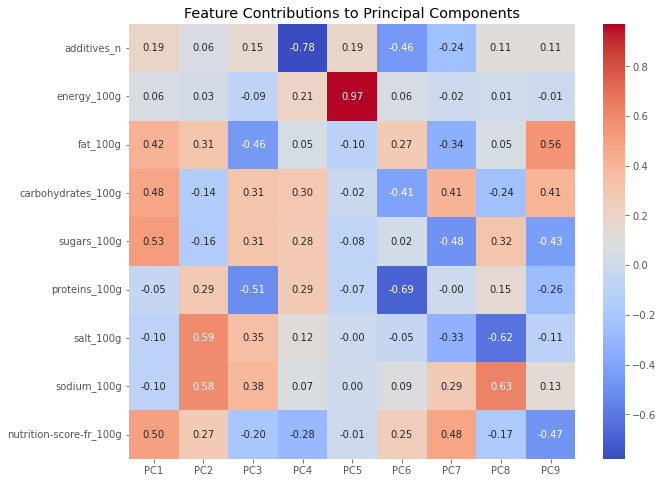

In [98]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
numeric_cols = ['additives_n', 'energy_100g', 'fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g']
# Select numerical features for PCA
# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_imputed[numeric_cols])

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Individual Explained Variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Explained Variance')
plt.ylabel('Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Explained Variance by PCA Components')
plt.legend(loc='best')
plt.show()

# Visualize first two components
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, c=df_imputed['additives_n'], cmap='viridis')
plt.colorbar(label='Number of Additives')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: First Two Components')
plt.show()

# Contribution of features to each component
components = pd.DataFrame(pca.components_, columns=numeric_cols, index=[f'PC{i+1}' for i in range(len(numeric_cols))])
print("Feature Contributions to Principal Components:")
print(components.T)

# Heatmap of feature contributions
plt.figure(figsize=(10, 8))
sns.heatmap(components.T, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Contributions to Principal Components')
plt.show()


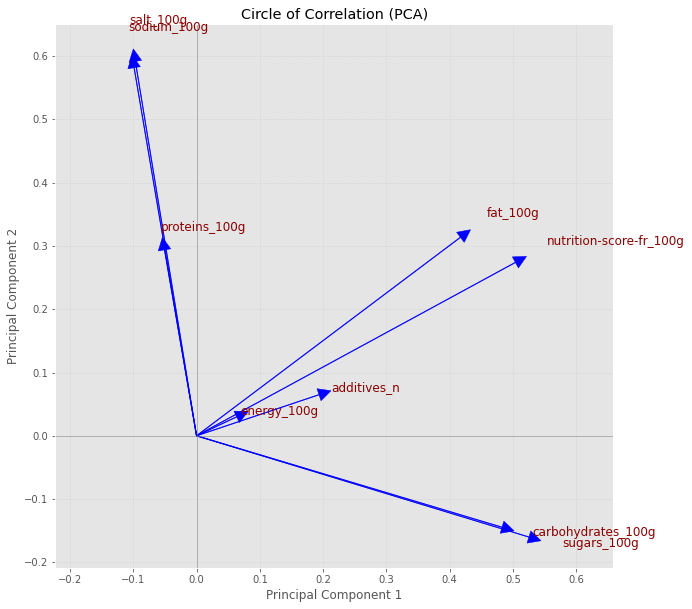

In [99]:
import numpy as np

# Function to plot the circle of correlation
def plot_correlation_circle(pca, components, feature_names, pc_x=0, pc_y=1):
    """
    Plots the circle of correlation for the given PCA components.
    - `pca`: The PCA object after fitting.
    - `components`: The PCA components matrix.
    - `feature_names`: List of feature names.
    - `pc_x`, `pc_y`: Indices of the PCs to plot (default: first two PCs).
    """
    plt.figure(figsize=(10, 10))
    plt.axhline(0, color='grey', linewidth=0.5)
    plt.axvline(0, color='grey', linewidth=0.5)
    plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)

    for i, feature in enumerate(feature_names):
        plt.arrow(0, 0, components[pc_x, i], components[pc_y, i],
                  head_width=0.02, head_length=0.02, fc='blue', ec='blue')
        plt.text(components[pc_x, i] * 1.1, components[pc_y, i] * 1.1,
                 feature, color='darkred', fontsize=12)

    # Circle of correlation
    circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--')
    plt.gca().add_artist(circle)

    plt.xlabel(f"Principal Component {pc_x + 1}")
    plt.ylabel(f"Principal Component {pc_y + 1}")
    plt.title("Circle of Correlation (PCA)")
    plt.axis('equal')
    plt.show()

# Call the function with your PCA results
plot_correlation_circle(pca, pca.components_, numeric_cols)


## Correlation entre variables quantitatives

In [ ]:
sample_df = merged_with_target.sample(n=1000, random_state=42)  # Replace 1000 with an appropriate size
categorical_features = ['ingredients_text', 'additives_n', 'additives',
       'additives_tags', 'nutrition_grade_fr', 'additives_fr',
       'additives_list']
  # Replace NaN with "Unknown"
contingency_table = pd.crosstab(sample_df['additives'], sample_df['additives_fr'])
display(contingency_table)

In [87]:
import pandas as pd
from scipy.stats import chi2_contingency
sample_df = merged_with_target.sample(n=2000, random_state=42) 
for col in categorical_features:
    sample_df[col] = sample_df[col].astype(str).fillna("Unknown")
# Loop through all pairs of categorical features to calculate Chi-squared
for i in range(len(categorical_features)):
    for j in range(i + 1, len(categorical_features)):
        feature1 = categorical_features[i]
        feature2 = categorical_features[j]
        
        # Create the contingency s
        contingency_table = pd.crosstab(sample_df[feature1], sample_df[feature2])
        
        # Perform the Chi-squared test
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        print(f"Chi-squared test between {feature1} and {feature2}:")
        print(f"Chi-squared statistic: {chi2}")
        print(f"P-value: {p}")
        print(f"Degrees of freedom: {dof}")
        print(f"Expected frequencies: \n{expected}")
        print("-" * 60)


Chi-squared test between ingredients_text and additives_n:
Chi-squared statistic: 34000.0
P-value: 0.32305566953065334
Degrees of freedom: 33881
Expected frequencies: 
[[0.3085 0.0055 0.004  ... 0.0335 0.0145 0.0155]
 [0.3085 0.0055 0.004  ... 0.0335 0.0145 0.0155]
 [0.3085 0.0055 0.004  ... 0.0335 0.0145 0.0155]
 ...
 [0.3085 0.0055 0.004  ... 0.0335 0.0145 0.0155]
 [0.3085 0.0055 0.004  ... 0.0335 0.0145 0.0155]
 [0.3085 0.0055 0.004  ... 0.0335 0.0145 0.0155]]
------------------------------------------------------------
Chi-squared test between ingredients_text and additives:
Chi-squared statistic: 3975999.99999998
P-value: 3.9464826353609965e-07
Degrees of freedom: 3962084
Expected frequencies: 
[[0.0005 0.0005 0.0005 ... 0.0005 0.0005 0.0005]
 [0.0005 0.0005 0.0005 ... 0.0005 0.0005 0.0005]
 [0.0005 0.0005 0.0005 ... 0.0005 0.0005 0.0005]
 ...
 [0.0005 0.0005 0.0005 ... 0.0005 0.0005 0.0005]
 [0.0005 0.0005 0.0005 ... 0.0005 0.0005 0.0005]
 [0.0005 0.0005 0.0005 ... 0.0005 0.0005 

Principaux points à retenir :

- #### Associations avec ingredients_text :
    De fortes associations significatives (valeurs p très faibles) sont observées avec des variables telles que 
    - **additives**, 
    - **additives_tags**, 
    - **additives_fr** et **additives_list**.

Il n’y a pas d’association significative avec nutrition_grade_fr (valeur p > 0,05), ce qui suggère l’absence de forte dépendance.

- #### Associations avec additives_n :
De fortes associations sont observées avec additives_tags, additives_fr et additives_list (valeurs p = 0,0).
La ​​relation avec nutrition_grade_fr montre une faible signification (valeur p ~ 0,03).

- #### Associations au sein des additifs et de ses variantes :
Des associations significatives existent entre additives, additives_tags, additives_fr et additives_list (valeurs p ~ 0,0).
Les statistiques du chi carré pour ces relations sont extrêmement élevées en raison de grands degrés de liberté, indiquant des relations fortes mais potentiellement surreprésentées en raison de la taille des données.

- nutrition_grade_fr et variables additives :
Une relation faible mais significative existe entre nutrition_grade_fr et additives_tags (p-value < 0,0001), suggérant une certaine dépendance.

# Summary

- Observations clés :

- Les premiers composants dominent :
    - Le premier composant principal explique la plus grande proportion de la variance, suivi du deuxième, du troisième, etc.
    - Pour cet ensemble de données, les deux ou trois premiers composants semblent capturer une part importante de la variance totale.

- Variance cumulative expliquée :
    - La courbe cumulative s'aplatit rapidement, indiquant que la majeure partie de la variance est capturée par les premiers composants. Par exemple, si vous souhaitez 80 % de la variance, vous n'aurez peut-êtr besoin que des 3 ou 4 premiers composants.

Longueur des flèches :
Plus la flèche est longue, plus la variable contribue aux composantes principales.
Par exemple, des variables comme fat_100g, glucides_100g et nutrition-score-fr_100g ont de longues flèches, ce qui signifie qu'elles contribuent de manière significative aux composantes.

Angle entre les flèches :
Des angles plus petits entre les flèches indiquent des corrélations positives.
Exemple : glucides_100g et sucres_100g sont positivement corrélés.
Des angles plus grands (proche de 90°) indiquent l'absence de corrélation.
Exemple : sel_100g et glucides_100g semblent non corrélés.
Des directions opposées indiquent des corrélations négatives.
Exemple : fibres_100g et nutrition-score-fr_100g peuvent avoir une légère corrélation négative.

Groupes de variables :
Les variables dans la même direction forment des groupes, indiquant qu'elles peuvent capturer des informations similaires.
Exemple : glucides_100 g et sucres_100 g pointent dans des directions similaires, suggérant qu’ils ont des effets similaires.